In [1]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import statsmodels.api as sm

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

# Helper Functions

In [2]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names


def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

## Global Variable

In [3]:
vars_to_plot = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

# Make RBC Model

In [4]:
rbc = ge.gEconModel('RBC_basic.gcn')

Model Building Complete.
Found:
	11 equations
	11 variables
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations

In [5]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

beta*U_t+1 + C_t**(1 - sigma_C)/(1 - sigma_C) - L_t**(sigma_L + 1)/(sigma_L + 1) - U_t

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 + lambda_t+1*(1 - delta)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve Model 

In [6]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.389582288179861e-19
Solution found, sum of squared residuals:  1.376341712129846e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [7]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
TC_ss             -3.073
U_ss            -148.616
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


In [8]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

# Get US data

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [9]:
indicators = ['NAEXKP01USQ652S', # GDP
              'USAGFCFQDSMEI', # Investment
              'USAPFCEQDSMEI', # HH consumption
              'TOTLQ', # non-farm hours worked
              'FEDFUNDS', # real interest rate
              'CES0500000003' # average hourly wage
             ]

from pandas_datareader.fred import FredReader
import os

if not os.path.isfile('us_fred_data.csv'):
    data = FredReader(symbols=indicators, start='1900', end=None).read()
    data.to_csv('us_fred_data.csv')
else:
    data = pd.read_csv('us_fred_data.csv', index_col=0, parse_dates=['DATE'], infer_datetime_format=True)

## Raw Data from FRED

<AxesSubplot: xlabel='DATE'>

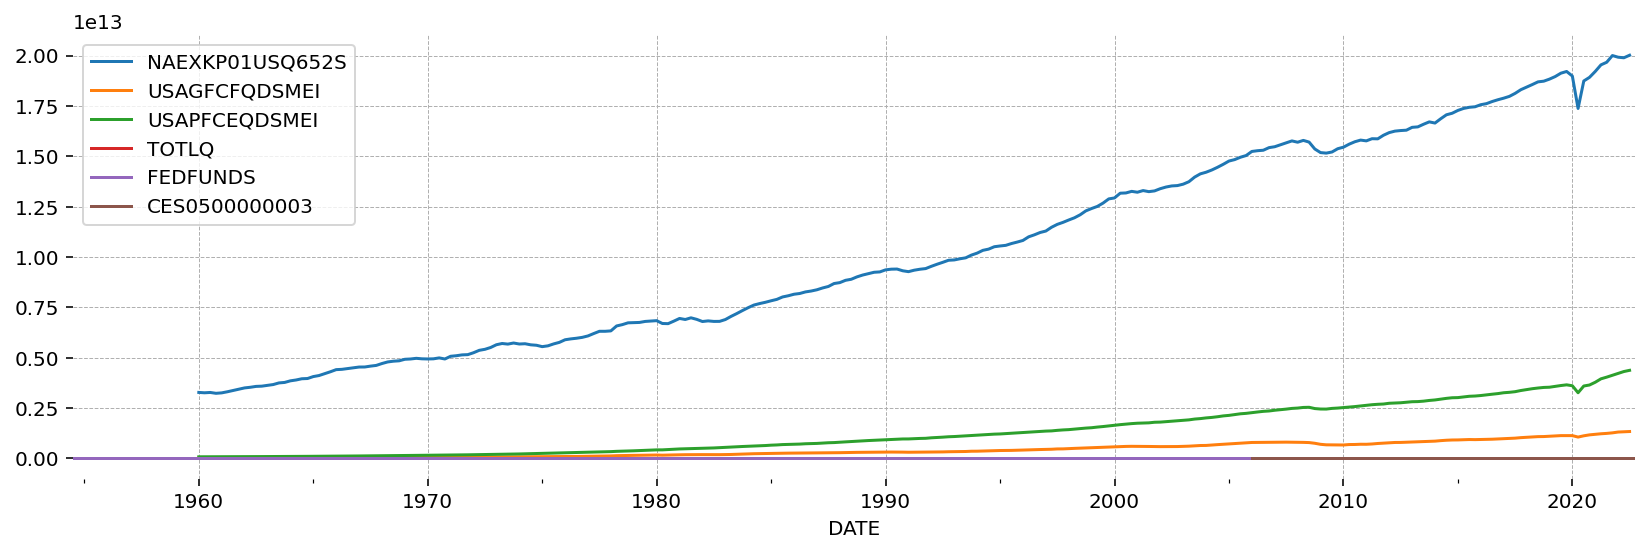

In [10]:
data.resample('QS').last().plot()

In [11]:
df = data.resample('QS').last()
df = df.rename(columns=dict(zip(indicators, ['Y', 'I', 'C', 'L', 'r', 'w'])))
df.index.name = 'Time'

# Regular at least 3 observed series
df.dropna(thresh=3, inplace=True)

In [12]:
def plot_df(df):
    fig = plt.figure(figsize=(14,6), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()


## Train Test Split

We need to split the last 10% of our data as a test set

In [13]:
#Compute 10% of the data
n_test = int(df.shape[0] * 0.1)
print(f'10% of the data is {n_test} observations')

# Use iloc to split. 
df_train = df.iloc[:-n_test, :]
df_test = df.iloc[-n_test:, :]

10% of the data is 25 observations


### Important!

From now on, we will ONLY work with the train set. It's cheating to use the test set from now on.

## Looking at the Data

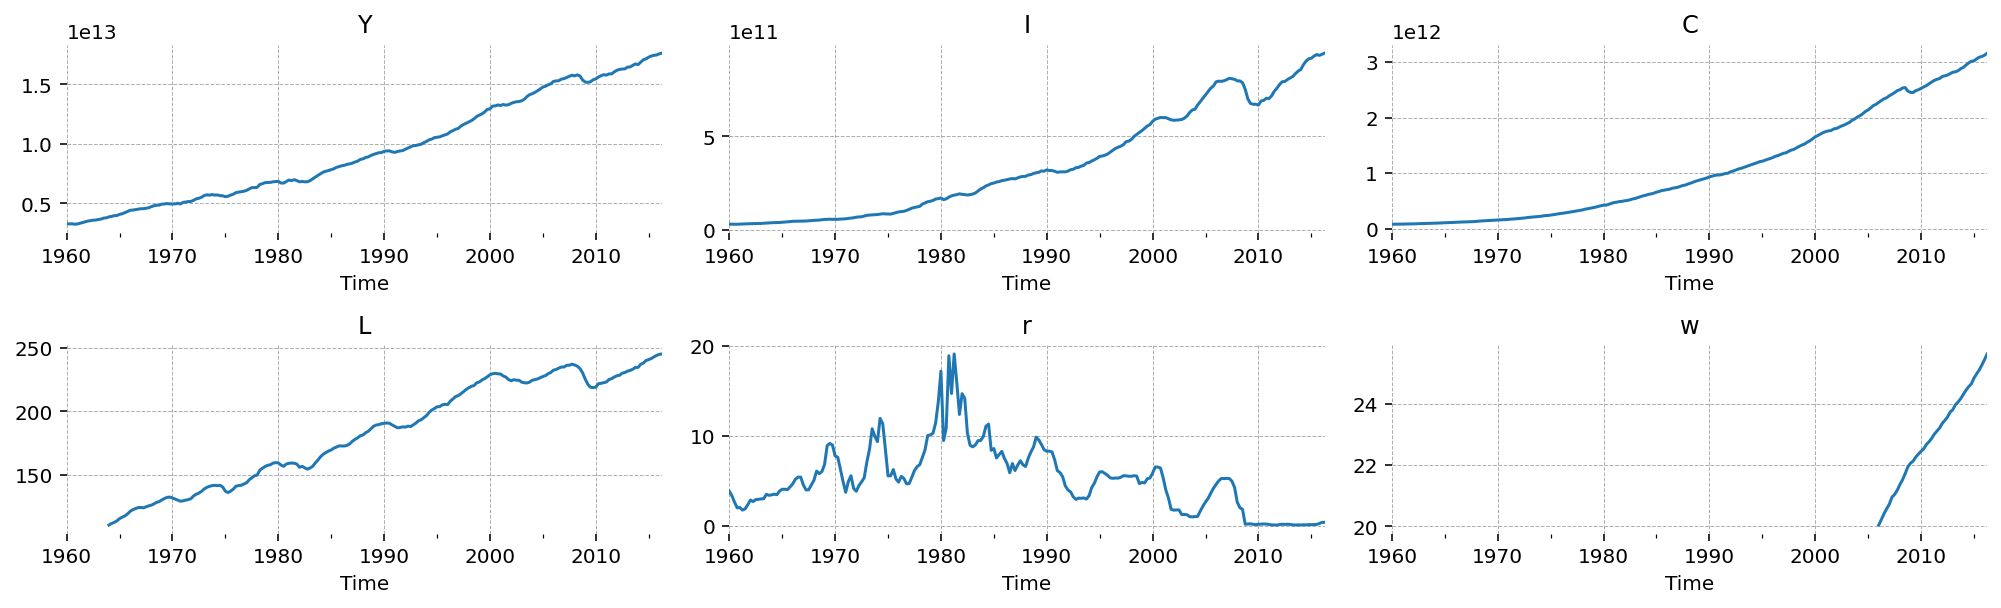

In [14]:
plot_df(df_train)

Looking at the plot, interest rates look like they might be stationary. We should check. It clearly has a non-zero mean, so we need to check the test with "constant only". The P-value is significant, so the series is stationary.

The specification with trend finds that it's stationary as well, and the trend P-value is significant. The typical procedure would have us remove the rend in this case. I'm not going to do that, because I know a priori that interest rates for the US are thought to be stationary around a non-zero trend. But I wouldn't blame you if you removed a linear trend based on this output.

In [15]:
ADF_test_summary(df_train['r'])

                                                      r                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.085         -3.469        0.043          5    -4.001      -3.431     -3.139
	Constant             0.788          3.163        0.002
	Trend               -0.003         -2.271        0.024
Constant Only               -0.061         -2.722        0.070          5    -3.460      -2.875     -2.574
	Constant             0.320          2.264        0.025
No Constant                 -0.018         -1.498        0.126          5    -2.576      -1.942     -1.616


## Preprocessing

These all need to be logged and de-trended. I'll use an OLS regression to remove the trend. Interest rates are already a percentage, so they don't need to be logged. They do need to be converted to decimal, though.

All the series are seasonally adjusted and in constant chained dollars. Actually I don't know if this is correct. It might be more correct to use raw series. There's no prices in this model so I don't think it matters, but in a full New Keynesian model with a monetary authority it might be correct to use unadjusted data. Need to check that data preparation paper again.

In [16]:
# Log and detrend everything that needs logging and detrending
# Make a design matrix. I will include a quadratic term based on the plots (they look like they have a 2nd
# derivative)
X = np.c_[np.ones(df.shape[0]), np.arange(df.shape[0]), np.arange(df.shape[0]) ** 2]

#split the design matrix into train/test as well
X_train = X[:-n_test, :]
X_test = X[-n_test:, :]


# Make a new df to hold my results
df_train_processed = df_train.copy()
df_test_processed = df_test.copy()
for variable in ['Y', 'I', 'C', 'L', 'w']:
    log_train_var = np.log(df_train_processed[variable])
    log_test_var = np.log(df_test_processed[variable])
    
    #Make sure to drop the missing values, or else everything will come out as np.nan
    mod = sm.OLS(log_train_var, X_train, missing='drop')
    res = mod.fit()
    df_train_processed[variable] = res.resid
    
    #Use .predict to get the detrended test data (without showing the model the test data!)
    test_hat = res.predict(X_test)
    test_res = log_test_var - test_hat
    df_test_processed[variable] = test_res
    
# Change annualized fedfunds to quarterly and remove mean (deviation from SS)
df_train_processed['r'] = (df_train_processed['r'] - df_train_processed['r'].mean()) / 400

# Here, we subtract the training mean from the test data
df_test_processed['r'] = (df_test_processed['r'] - df_train_processed['r'].mean()) / 400


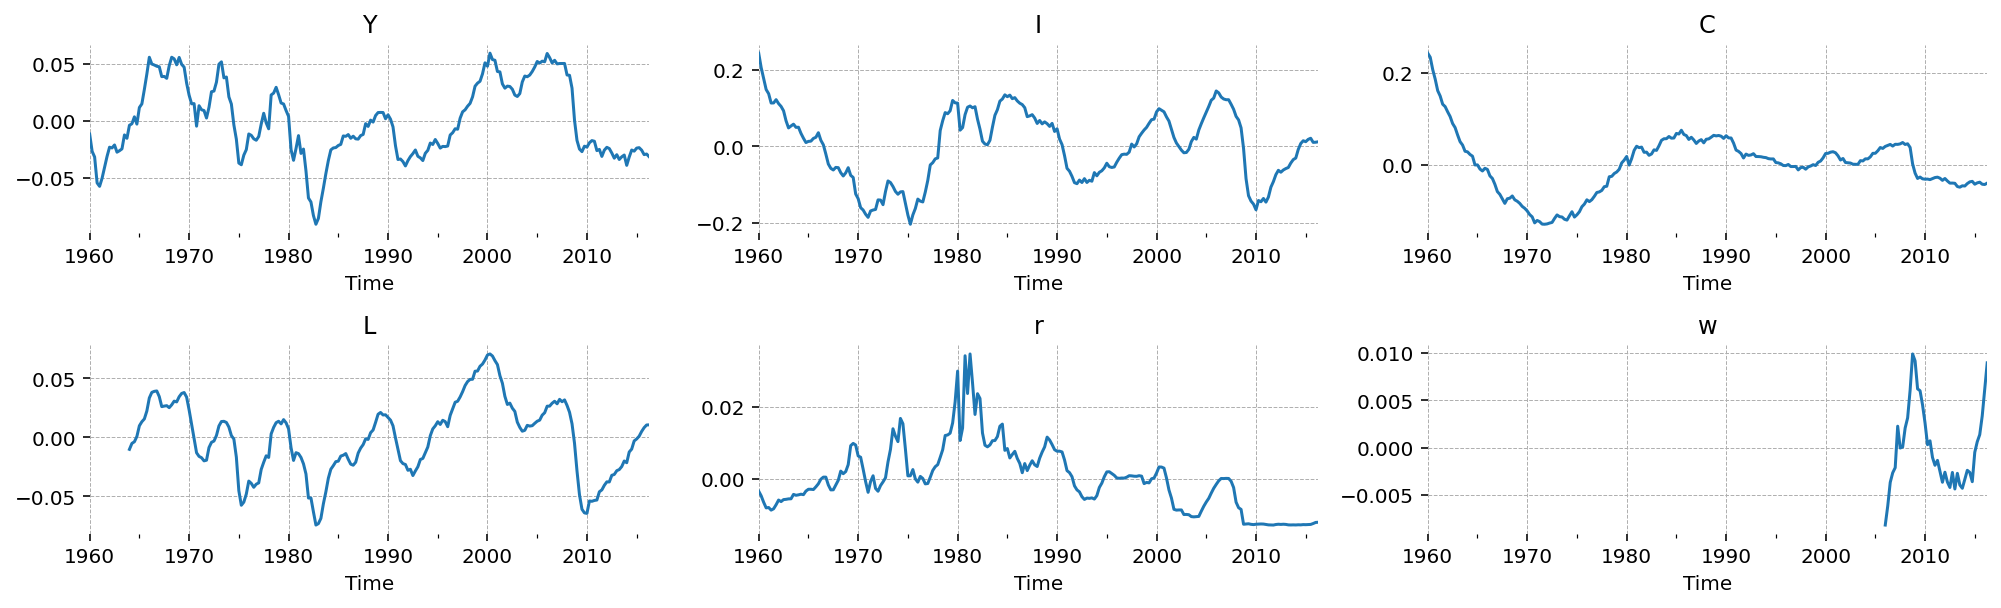

In [17]:
plot_df(df_train_processed)

We can peek at `df_test_processed` just to make sure it didn't get messed up.

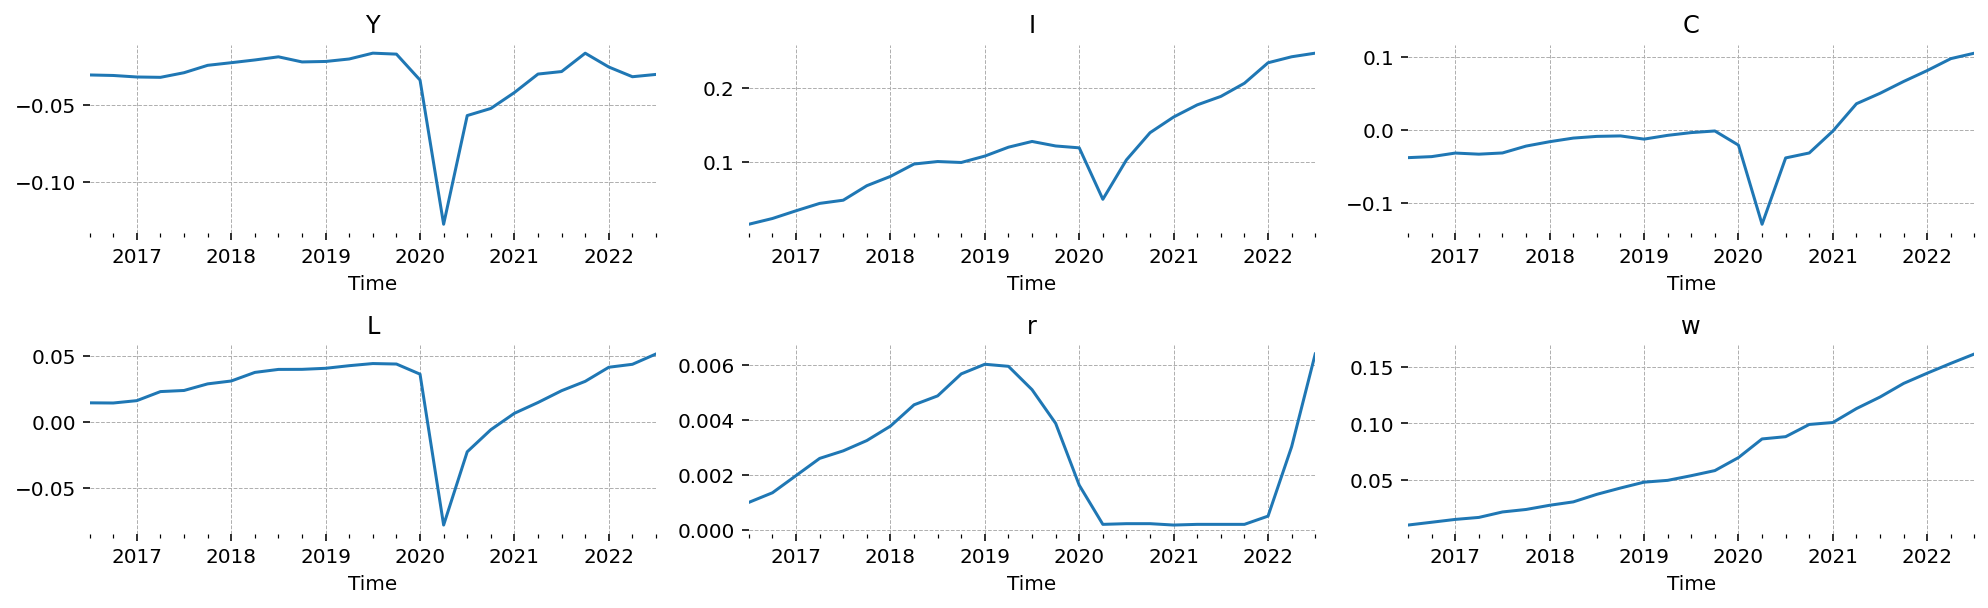

In [18]:
plot_df(df_test_processed)

## Check stationarity after tranformation

We want to check the "no constant" model, because all the plots are centered on zero (because we included a constant in our regression!). If the p-value is significant, the series is stationary (ADF has H0: Series is non-stationary).

As we can see, all of them are ruled stationary at at least the 10% level of significance.

In [19]:
ADF_test_summary(df_train_processed, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.048         -3.104        0.105          2    -4.000      -3.430     -3.139
	Constant             0.001          0.575        0.566
	Trend               -0.000         -0.622        0.535
Constant Only               -0.048         -3.114        0.026          2    -3.460      -2.875     -2.574
	Constant             0.000          0.072        0.943
No Constant                 -0.048         -3.121        0.002          2    -2.576      -1.942     -1.616
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

# Maximum Likelihood Estimation

To estimate the model, we first need to compile from a gEconpy model to a Statsmodels.api model. There's a helper function called `compile_to_statsmodels` to help us with that.

In [21]:
MLEModel = ge.compile_to_statsmodels(rbc)

Maximum likelihood estiamtion of DSGE models is extremely difficult. Many parameters are not identified. Recall that was saw in TD, for example, that changing `sigma_L` didn't change the shape of the utility function at all. As a result, we really can't estimate `sigma_L`.

We might also think that more data = better, but this isn't always the case. Remember that **all** variation in our model comes from the technology shock. If we include low-quality data that has non-technology noise, we will get the wrong answers.

Because this is all so hard, we need to go slow and use some helpful tools.

## Advice 1: Begin Small

We will begin by showing the model only a single data series. I will start with GDP.

To fit the model, we need to make 4 dictionaries:

1. `param_start_dict` gives starting values for parameters we want to estimate. Any parameter NOT in this dictionary will be frozen at the value you gave it in the GCN file.

2. `shock_start_dict` gives a starting value for the standard deviation of the shocks. You have to give something for all these values.

3. `noise_start_dict` gives starting values for **observation noise** associated with data you show the model. Observation noise tells the model that we don't trust the data -- data has normally distributed noise added. So if you give a standard deviation of 0.01 to GDP, you are saying that the actual GDP could be +2% or -2% from what the data show.

    If you have untrustworthy data, it is good to add observation noise. The other reason to add observation noise is to allow you to show the model more data. More on this later.
    
4. `param_transforms` tells the model how to restrict the search for parameter values. For example, we know that `alpha` needs to be between 0 and 1. We use this dictionary to tell the model this information, and ensure our estimation result will respect these restricitons.

To begin small, let's just estimate two variable: `rho_A` and `sigma_A`.

In [22]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# I only want to estimate rho_A, so I only put rho_A in the start_param_dict
param_start_dict = {'rho_A':0.85}

# Likewise, I want to estimate the shock on epsilon_A, so I put that in shock_start_dict
shock_start_dict = {
    'epsilon_A':0.5
}

# We will 100% trust the GDP data, so noise_start_dict is empty.
noise_start_dict = {}

# We want rho_A to be somewhere between 0 and 1, so we use an IntervalTransformer to restrict it.
# Don't actually pick 0 and 1, because you can get divide by zero errors. Instead pick numbers really close.
param_transforms = {'rho_A':IntervalTransformer(low=1e-2, high=0.9999)}


# Build the model!
mle_mod = MLEModel(df_train_processed[['Y']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

### Estimation

To estimate, we call the `.fit()` method. Inside, this will use a minimization algorithm to find the parameters that make the negative log likelihood of the data as small as possible (this is the same as making the positive log likelihood as big as possible).

There are many algorithms to find minima. They can be divided into two groups: those that use gradients, and those that do not. Gradient solvers, like [LBFGS](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) are "better", but you need to have gradients to use them. We only have approximate gradients. Also they can easily get stuck in **local** optima. That is, the find a small minimum in the likelihood space and stay there, even though there is a way better minimum somewhere else.

So it's good to use a non-gradient solver, like [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder-Mead). Probably the best, though, is [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing), which allows us to explore large state space, without gradients, and avoid local optima. The tradeoff is that simulated annealing is slow.

You can try some combination of these. I'll be using something similar to simulated annealing in this notebook, called the `basinhoppping` algorithm. This is because the likelihood function we are working with has an extremely complex geometry, and it's tough to get the other solvers to work. They very easily get stuck on local optima, so I'm of the belief that a global solver is needed. 

I got **much** better results with `basinhopping` than the others, but you are of course welcome to try anything and report what you find.

In [23]:
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -3.06851
basinhopping step 1: f -3.05825 trial_f -3.05825 accepted 1  lowest_f -3.06851
basinhopping step 2: f -2.70112 trial_f -2.70112 accepted 1  lowest_f -3.06851
basinhopping step 3: f -3.06189 trial_f -3.06189 accepted 1  lowest_f -3.06851
basinhopping step 4: f -3.06189 trial_f -2.72396 accepted 0  lowest_f -3.06851
basinhopping step 5: f -3.07043 trial_f -3.07043 accepted 1  lowest_f -3.07043
found new global minimum on step 5 with function value -3.07043
basinhopping step 6: f -3.07662 trial_f -3.07662 accepted 1  lowest_f -3.07662
found new global minimum on step 6 with function value -3.07662
basinhopping step 7: f -3.07662 trial_f -2.83491 accepted 0  lowest_f -3.07662
basinhopping step 8: f -3.05151 trial_f -3.05151 accepted 1  lowest_f -3.07662
basinhopping step 9: f -3.0802 trial_f -3.0802 accepted 1  lowest_f -3.0802
found new global minimum on step 9 with function value -3.0802
basinhopping step 10: f -3.09395 trial_f -3.09395 accepted 1  lowest_

basinhopping step 61: f -3.10696 trial_f -3.10696 accepted 1  lowest_f -3.11822
basinhopping step 62: f -3.08889 trial_f -3.08889 accepted 1  lowest_f -3.11822
basinhopping step 63: f -3.0988 trial_f -3.0988 accepted 1  lowest_f -3.11822
basinhopping step 64: f -3.0988 trial_f -3.09397 accepted 0  lowest_f -3.11822
basinhopping step 65: f -3.1121 trial_f -3.1121 accepted 1  lowest_f -3.11822
basinhopping step 66: f -3.10207 trial_f -3.10207 accepted 1  lowest_f -3.11822
basinhopping step 67: f -3.11183 trial_f -3.11183 accepted 1  lowest_f -3.11822
basinhopping step 68: f -3.1172 trial_f -3.1172 accepted 1  lowest_f -3.11822
basinhopping step 69: f -3.09721 trial_f -3.09721 accepted 1  lowest_f -3.11822
basinhopping step 70: f -3.11186 trial_f -3.11186 accepted 1  lowest_f -3.11822
basinhopping step 71: f -3.11508 trial_f -3.11508 accepted 1  lowest_f -3.11822
basinhopping step 72: f -3.10673 trial_f -3.10673 accepted 1  lowest_f -3.11822
basinhopping step 73: f -3.11216 trial_f -3.112

In [24]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  226
Model:                      DSGEModel   Log Likelihood                 315.020
Date:                Sun, 04 Dec 2022   AIC                           -626.040
Time:                        05:10:50   BIC                           -619.199
Sample:                    01-01-1960   HQIC                          -623.280
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9872      0.025     39.831      0.000       0.939       1.036
sigma2.epsilon_A     0.0086      0.002      4.588      0.000       0.005       0.012
===================================================================================
Ljung-Box (L1) (Q):                  19.35   Jarque-Bera (JB):                35.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Predictions

The Kalman Filter has 3 types of outputs: Predictions, Filter, and Smoother.

First and foremost, it is important to understand that the Kalman Filter is a iterative algorithm. At each time step, the filter updates using all past information. That means that we only every predict, at most, just one step.

So "Prediction" gives this one-step ahead prediction, given the data. You can see that for Y, it is spot on. This is because we showed the model the data for Y, so it adapted itself entirely to the job of fitting Y. 

"Filter" gives an optimal combination of the model prediction ($x_{t+1} = Ax_t$) and the data. The combination of the prediction is based on the **observation noise**. Since we didn't give the model any observation noise, it will *throw away the model prediction entirely and use only the data*. This means that the filter **IS** the data. As a result, we don't really care about it. But another consequence that at every timestep, the prediction is perfectly centered on the data. This is why Y is fit so well.

"Smoother" also gives the optimal combination of the prediction and the data, but it does so taking into account the past (filter also does this) and the future (filter does NOT do this). Smoother is nice when we want to estimate missing data or hidden states.

### Some interpertation of the prediction plots

We can see that it also does a good job for I and C, but it does a much better job for I than for C. It seems like the period after 2000 is also better explained by this model than the period before 2000. L and R are miserably bad. R is much more volatile than in reality, while L is much too stable! 

Notice that the error bars are all bigger before 1970 than after. This is because there is missing data for L here. Evidently, L is an important driver of K (does this make sense?)

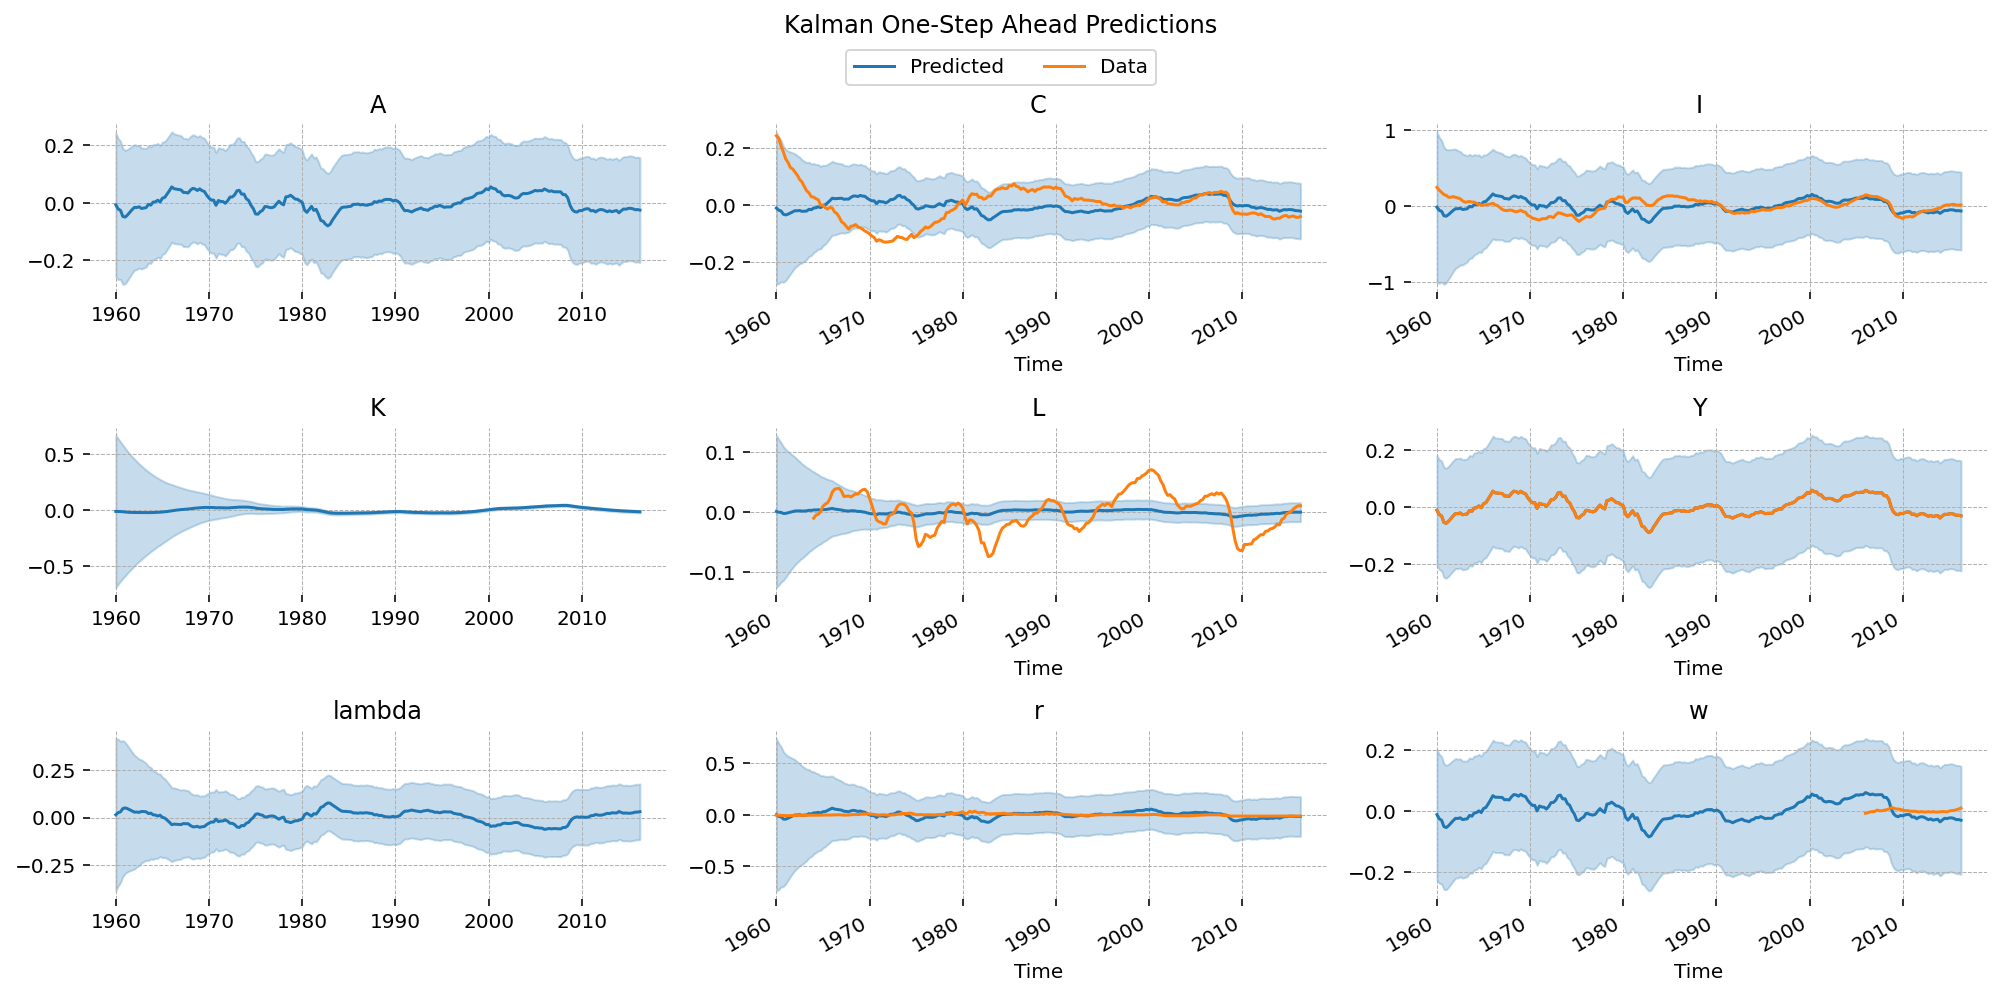

In [25]:
plot_sm_results(mle_res, df_train_processed, var_names=vars_to_plot)

### MLE Kalman Smoother Output

The Kalman smoother takes into account both future and past information. In principle, it extracts the best possible signal from noisy data

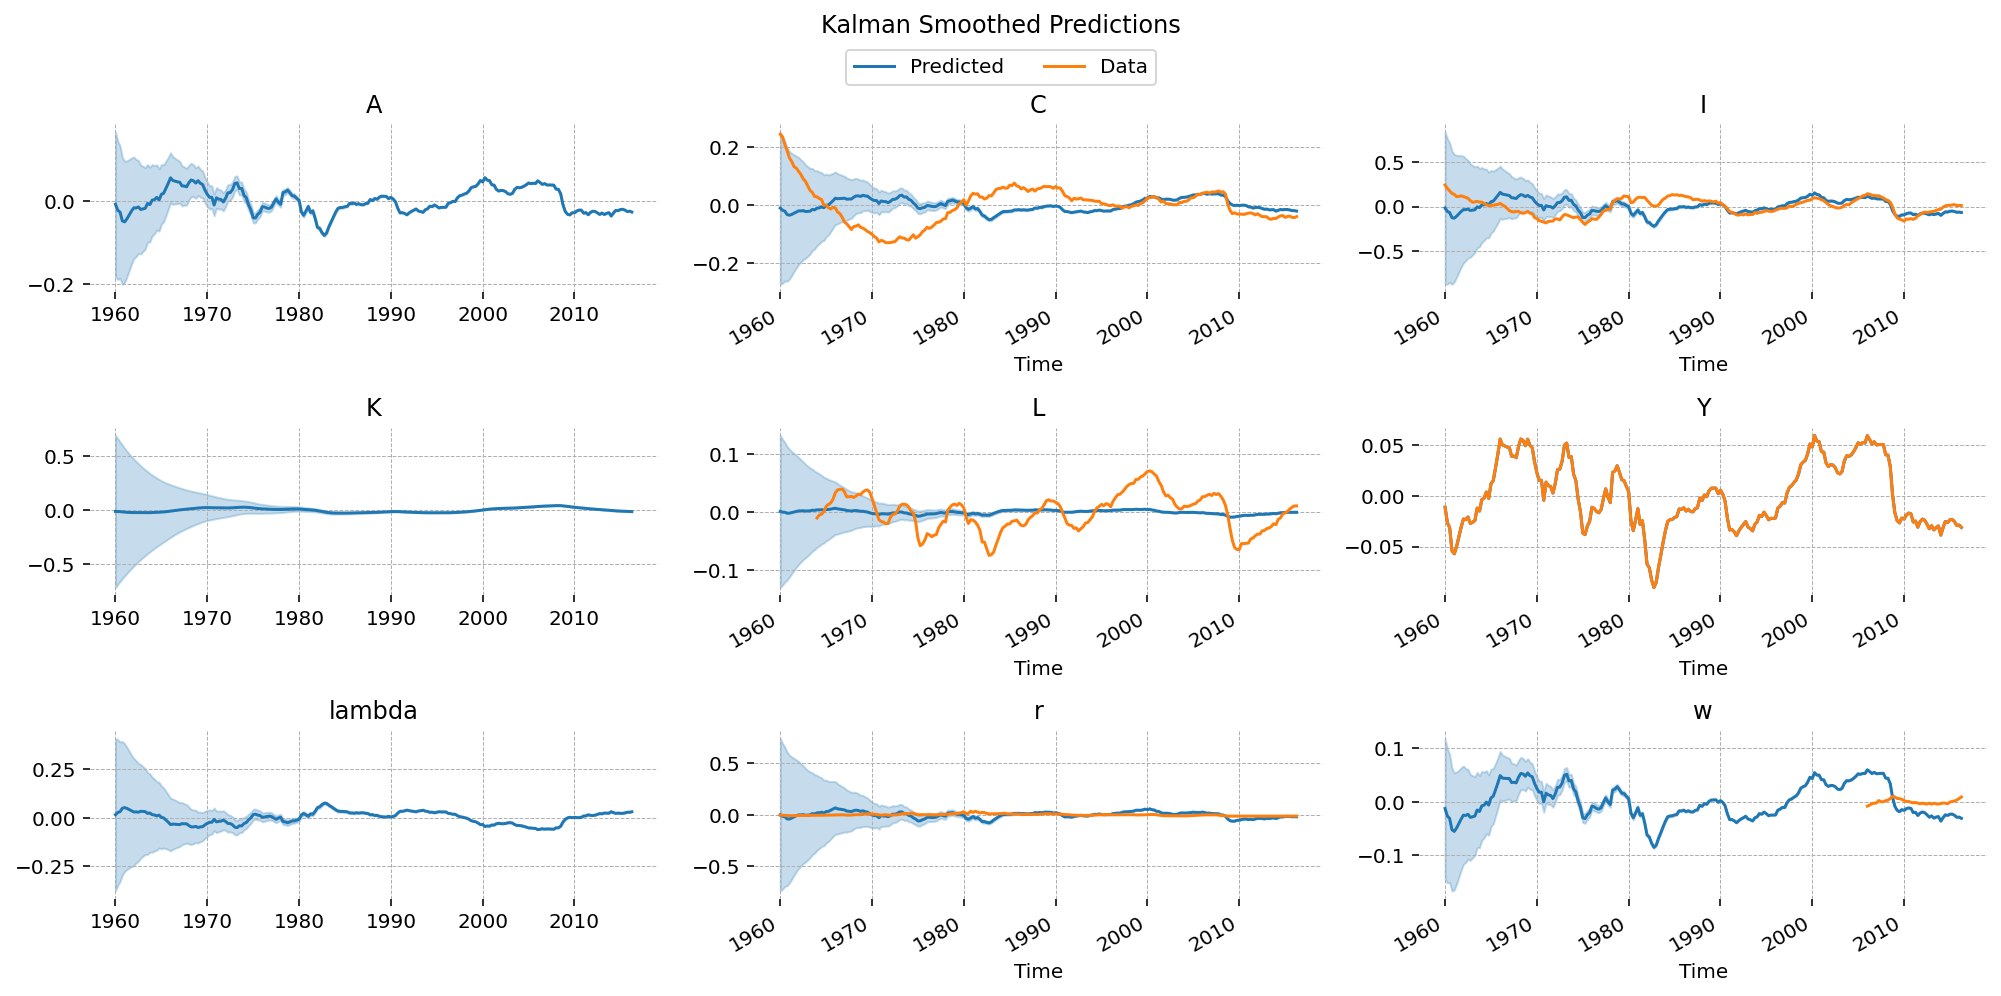

In [26]:
plot_sm_results(mle_res, df_train_processed, 'smoothed', var_names=vars_to_plot)

## Forecasting

This is all nice, but the real test of the model is forecasting. We can get forecasts by using the `.get_forecast` method.

In [27]:
mle_forecast = mle_res.get_forecast(steps=n_test)

This gives a `PredictionResultsWrapper` object that has two important methods: `predicted_mean` and `var_pred_mean`. These are the average prediction and the confidence intervals. We can use them to plot our predictions.

Part of this exercise is to show you how nonsense it is to make long-range forecasts. Look at the scale of the x-axis! By 2018, our error bars are out to 50% -- we're saying that GDP could be anywhere from -50% of the trendline, to +50% of the trendline! By 2022% we're at 80% -- essentailly saying nothing at all.

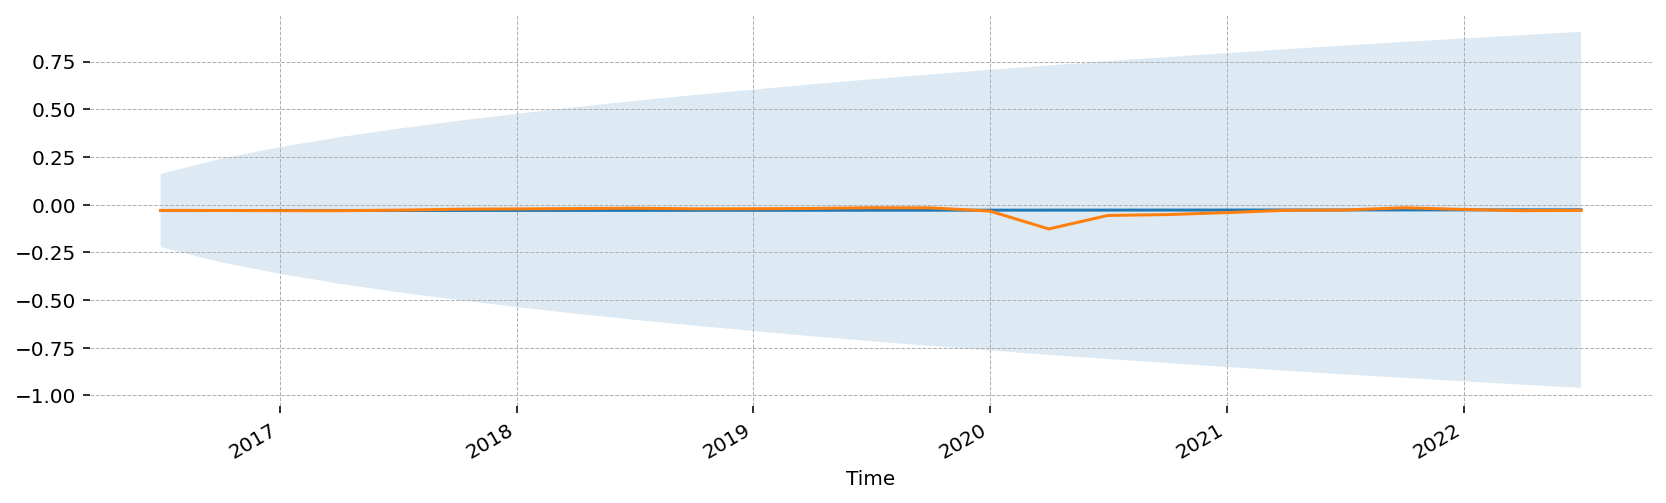

In [28]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
df_test_processed.Y.plot(ax=ax)
plt.show()

Let's remove the 95% CI to see what's going on with the mean prediction and the real data. Without any shocks (remember, they are all zero in expectation), the model is slowly drifting back towards the steady state. This ends up being a reasonable prediction, as the actual data also drifts back upwards, though more quickly than our model predicts.

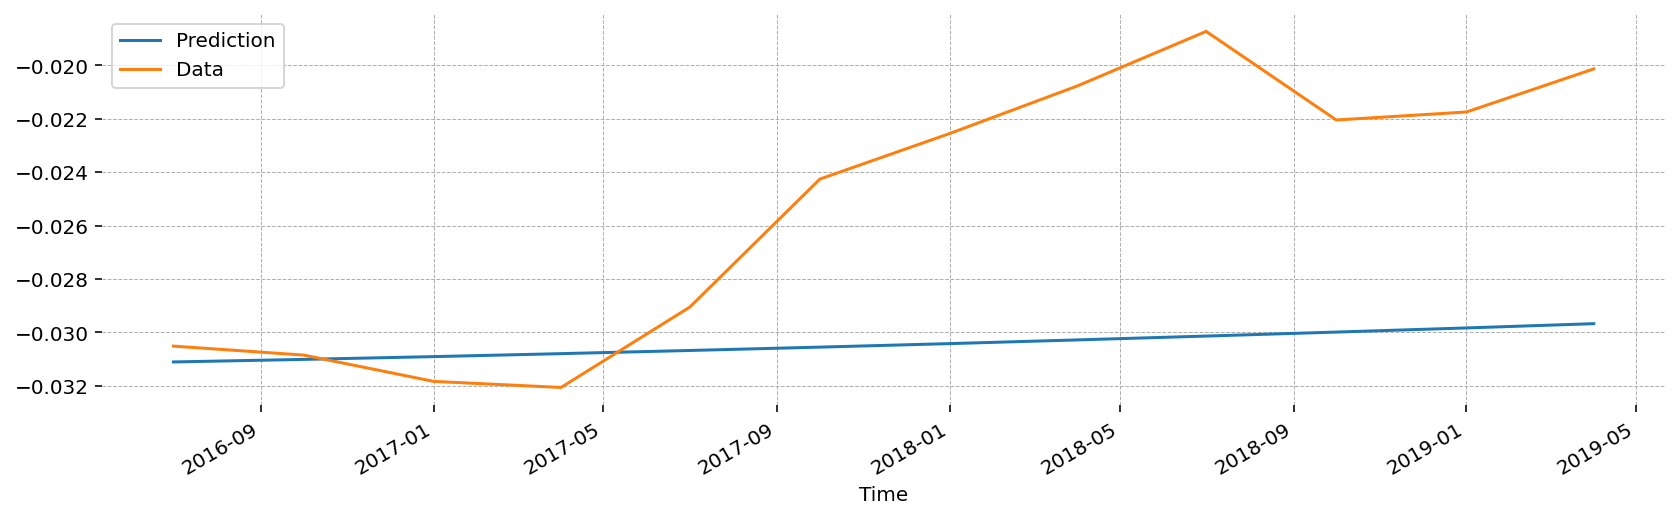

In [29]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
df_test_processed.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

## What if we add observation noise?

It seems weird that our model prefectly predicts GDP, and it is. We could try adding some observation noise, just to see what happens. 

Recall that to do this, we just add the name of the variable we want to add noise to into the `noise_start_dict`.

In [30]:

param_start_dict = {'rho_A':0.85}
shock_start_dict = {'epsilon_A':0.5}

# Let's say that maybe GDP data is incorrect by up to 2%
noise_start_dict = {'Y':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=1e-2, high=0.99)}

# Build the model!
mle_noise_mod = MLEModel(df_train_processed[['Y']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [32]:
mle_res_noise = mle_noise_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -3.04991
basinhopping step 1: f -2.99231 trial_f -2.99231 accepted 1  lowest_f -3.04991
basinhopping step 2: f -2.99231 trial_f -2.63191 accepted 0  lowest_f -3.04991
basinhopping step 3: f -3.03961 trial_f -3.03961 accepted 1  lowest_f -3.04991
basinhopping step 4: f -3.00914 trial_f -3.00914 accepted 1  lowest_f -3.04991
basinhopping step 5: f -3.0306 trial_f -3.0306 accepted 1  lowest_f -3.04991
basinhopping step 6: f -3.02503 trial_f -3.02503 accepted 1  lowest_f -3.04991
basinhopping step 7: f -3.02503 trial_f -1.99002 accepted 0  lowest_f -3.04991
basinhopping step 8: f -3.00757 trial_f -3.00757 accepted 1  lowest_f -3.04991
basinhopping step 9: f -2.87113 trial_f -2.87113 accepted 1  lowest_f -3.04991
basinhopping step 10: f -3.0066 trial_f -3.0066 accepted 1  lowest_f -3.04991
basinhopping step 11: f -3.0066 trial_f -2.98319 accepted 0  lowest_f -3.04991
basinhopping step 12: f -3.0066 trial_f -1.99113 accepted 0  lowest_f -3.04991
basinhopping step 13: f

basinhopping step 63: f -2.92244 trial_f -2.92244 accepted 1  lowest_f -3.08271
basinhopping step 64: f -2.92218 trial_f -2.92218 accepted 1  lowest_f -3.08271
basinhopping step 65: f -2.9591 trial_f -2.9591 accepted 1  lowest_f -3.08271
basinhopping step 66: f -3.0457 trial_f -3.0457 accepted 1  lowest_f -3.08271
basinhopping step 67: f -2.85364 trial_f -2.85364 accepted 1  lowest_f -3.08271
basinhopping step 68: f -3.07794 trial_f -3.07794 accepted 1  lowest_f -3.08271
basinhopping step 69: f -3.07422 trial_f -3.07422 accepted 1  lowest_f -3.08271
basinhopping step 70: f -3.08239 trial_f -3.08239 accepted 1  lowest_f -3.08271
basinhopping step 71: f -3.08191 trial_f -3.08191 accepted 1  lowest_f -3.08271
basinhopping step 72: f -3.00663 trial_f -3.00663 accepted 1  lowest_f -3.08271
basinhopping step 73: f -3.02921 trial_f -3.02921 accepted 1  lowest_f -3.08271
basinhopping step 74: f -2.93557 trial_f -2.93557 accepted 1  lowest_f -3.08271
basinhopping step 75: f -2.97244 trial_f -2.

The model wants to reject the notion of noise on `Y`. The estimated variance is basically 0, which says we trust this data completely. Since the result is zero noise, the graphs are going to essentially be the same. We can just move on.

In [33]:
mle_res_noise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  226
Model:                      DSGEModel   Log Likelihood                 288.441
Date:                Sun, 04 Dec 2022   AIC                           -570.882
Time:                        05:15:30   BIC                           -560.620
Sample:                    01-01-1960   HQIC                          -566.740
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9247      1.423      0.650      0.516      -1.864       3.714
sigma2.epsilon_A     0.0089      0.184      0.048      0.961      -0.352       0.370
sigma2.Y          1.356e-05      0.146   9.28e-05      1.000      -0.287       0.287
===================================================================================
Ljung-Box (L1) (Q):                  26.96   Jarque-Bera (JB):                40.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

## Advice 2: Stochastic Singularity

Let's add another observed data. `L` was fit miserably bad, so let's add that into the model.

At the same time, we can try to estimate `sigma_C`. Why not?

In [34]:

# We want to estimate sigma_C as well now, so add it to the param_start_dict
param_start_dict = {'rho_A':0.85,
                    'sigma_C':1.5}

shock_start_dict = {'epsilon_A':0.5}

# Back to trusting the data
noise_start_dict = {}

# sigma_C should be bigger than 1, but other than that we don't care what it is.
param_transforms = {'rho_A':IntervalTransformer(low=1e-2, high=0.9999),
                    'sigma_C':IntervalTransformer(low=1.001, high=20.0)}

# Build the model!
two_var_mod = MLEModel(df_train_processed[['Y', 'L']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

Huh. We failed to converge. What's up?

In [35]:
two_var_res = two_var_mod.fit(method='lbfgs', maxiter=1_000, disp=0)

/Users/jessegrabowski/opt/anaconda3/envs/econ/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Notice that the log likelihood is something in the trillions! 

We're encountering a phenomenon called **stochastic singularity**. Basically, **YOU CANNOT SHOW THE MODEL MORE VARIABLES THAN YOU HAVE SHOCKS IN THE MODEL**. If you do, everything will blow up like this. For the purposes of estimation, the definition of "shock" is a "variance term". Here, we have one variance term: `sigma2.epsilon_A`. We need one more.

In [36]:
two_var_res.summary()

/Users/jessegrabowski/opt/anaconda3/envs/econ/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:2979: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             ['Y', 'L']   No. Observations:                  226
Model:                      DSGEModel   Log Likelihood       -894141595344.019
Date:                Sun, 04 Dec 2022   AIC                  1788283190694.037
Time:                        05:15:45   BIC                  1788283190704.299
Sample:                    01-01-1960   HQIC                 1788283190698.178
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.8500   3.45e-20   2.46e+19      0.000       0.850       0.850
sigma_C              1.5000         -0       -inf      0.000       1.500       1.500
sigma2.epsilon_A     0.5000    2.4e-18   2.08e+17      0.000       0.500       0.500
===================================================================================
Ljung-Box (L1) (Q):            45.03, 0.00   Jarque-Bera (JB):     26.70, 468337.75
Prob(Q):                        0.00, 0.95   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.53, 0.00   Skew:                     -0.52, 14.93
Prob(H) (two-sided):            0.01, 0.00   Kurtosis:                 4.33, 224.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

### Fixing Stochastic Singularity

There are two ways to fix the stochastic singularity. There's a lazy way and a principled way. The lazy way is to add an observation noise. This counts as a shock, so it will fix the problem. It's lazy because we're just giving the model an extra degree of freedom, but we're not really doing so in a way that has any economic meaning.

The principled way is to add another shock to the model. 

We'll take the lazy route for now.

In [37]:

# We want to estimate sigma_C as well now, so add it to the param_start_dict
param_start_dict = {'rho_A':0.85,
                    'sigma_C':1.5}

shock_start_dict = {'epsilon_A':0.5}

# Distrust labor data to fix the stochastic singularity
noise_start_dict = {'L':0.05}

# sigma_C should be bigger than 1, but other than that we don't care what it is.
param_transforms = {'rho_A':IntervalTransformer(low=1e-2, high=0.9999),
                    'sigma_C':IntervalTransformer(low=1.1, high=10.0)}

# Build the model!
two_var_mod = MLEModel(df_train_processed[['Y', 'L']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

Now that the singularity is fixed, we get estimates.

The model evidently isn't very confident in either of the estimates for `rho_A` or `sigma_C`. Neither is statsitically significant, although I wouldn't take significance too seriously here (we're using an approximate jacobain at a point with no guarantee to be the global optimum to compute them).

What is interesting is that the model settled on a much lower value of `rho_A` for this run. This could be due to run-to-run variation in the basinhopping algorithm, or it could be the influence of the labor series.

In [38]:
two_var_res = two_var_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -1.99638
basinhopping step 1: f -2.71455 trial_f -2.71455 accepted 1  lowest_f -2.71455
found new global minimum on step 1 with function value -2.71455
basinhopping step 2: f -4.53928 trial_f -4.53928 accepted 1  lowest_f -4.53928
found new global minimum on step 2 with function value -4.53928
basinhopping step 3: f -4.2944 trial_f -4.2944 accepted 1  lowest_f -4.53928
basinhopping step 4: f -4.2944 trial_f -1.88058 accepted 0  lowest_f -4.53928
basinhopping step 5: f -4.2944 trial_f -3.26495 accepted 0  lowest_f -4.53928
basinhopping step 6: f -4.2944 trial_f -2.27679 accepted 0  lowest_f -4.53928
basinhopping step 7: f -4.14476 trial_f -4.14476 accepted 1  lowest_f -4.53928
basinhopping step 8: f -4.88343 trial_f -4.88343 accepted 1  lowest_f -4.88343
found new global minimum on step 8 with function value -4.88343
basinhopping step 9: f -4.88343 trial_f -3.86651 accepted 0  lowest_f -4.88343
basinhopping step 10: f -4.88343 trial_f -1.99663 accepted 0  lowest_f

basinhopping step 67: f -4.35575 trial_f -4.35575 accepted 1  lowest_f -5.01116
basinhopping step 68: f -4.87093 trial_f -4.87093 accepted 1  lowest_f -5.01116
basinhopping step 69: f -4.87093 trial_f -3.85007 accepted 0  lowest_f -5.01116
basinhopping step 70: f -4.87093 trial_f -4.80235 accepted 0  lowest_f -5.01116
basinhopping step 71: f -4.87093 trial_f -1.95469 accepted 0  lowest_f -5.01116
basinhopping step 72: f -4.87093 trial_f -2.4078 accepted 0  lowest_f -5.01116
basinhopping step 73: f -4.87093 trial_f 18.7829 accepted 0  lowest_f -5.01116
basinhopping step 74: f -4.87093 trial_f -3.74182 accepted 0  lowest_f -5.01116
basinhopping step 75: f -4.87093 trial_f -1.57456 accepted 0  lowest_f -5.01116
basinhopping step 76: f -4.87093 trial_f -2.41915 accepted 0  lowest_f -5.01116
basinhopping step 77: f -4.26043 trial_f -4.26043 accepted 1  lowest_f -5.01116
basinhopping step 78: f -4.26043 trial_f -1.56517 accepted 0  lowest_f -5.01116
basinhopping step 79: f -4.26043 trial_f -

In [39]:
two_var_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             ['Y', 'L']   No. Observations:                  226
Model:                      DSGEModel   Log Likelihood                 437.352
Date:                Sun, 04 Dec 2022   AIC                           -866.705
Time:                        05:17:59   BIC                           -853.023
Sample:                    01-01-1960   HQIC                          -861.183
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.7663      0.513      1.493      0.135      -0.240       1.772
sigma_C              1.7908     31.040      0.058      0.954     -59.047      62.629
sigma2.epsilon_A     0.0095      0.012      0.793      0.428      -0.014       0.033
sigma2.L             0.0324      0.018      1.840      0.066      -0.002       0.067
===================================================================================
Ljung-Box (L1) (Q):          89.22, 217.72   Jarque-Bera (JB):          10.62, 1.29
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.53
Heteroskedasticity (H):         0.72, 2.95   Skew:                     -0.39, -0.00
Prob(H) (two-sided):            0.15, 0.00   Kurtosis:                   3.73, 2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

One nice improvement we see in these plots is that we have more uncertainty around `L`, and the data is now encompassed by the 95% confidence interval.

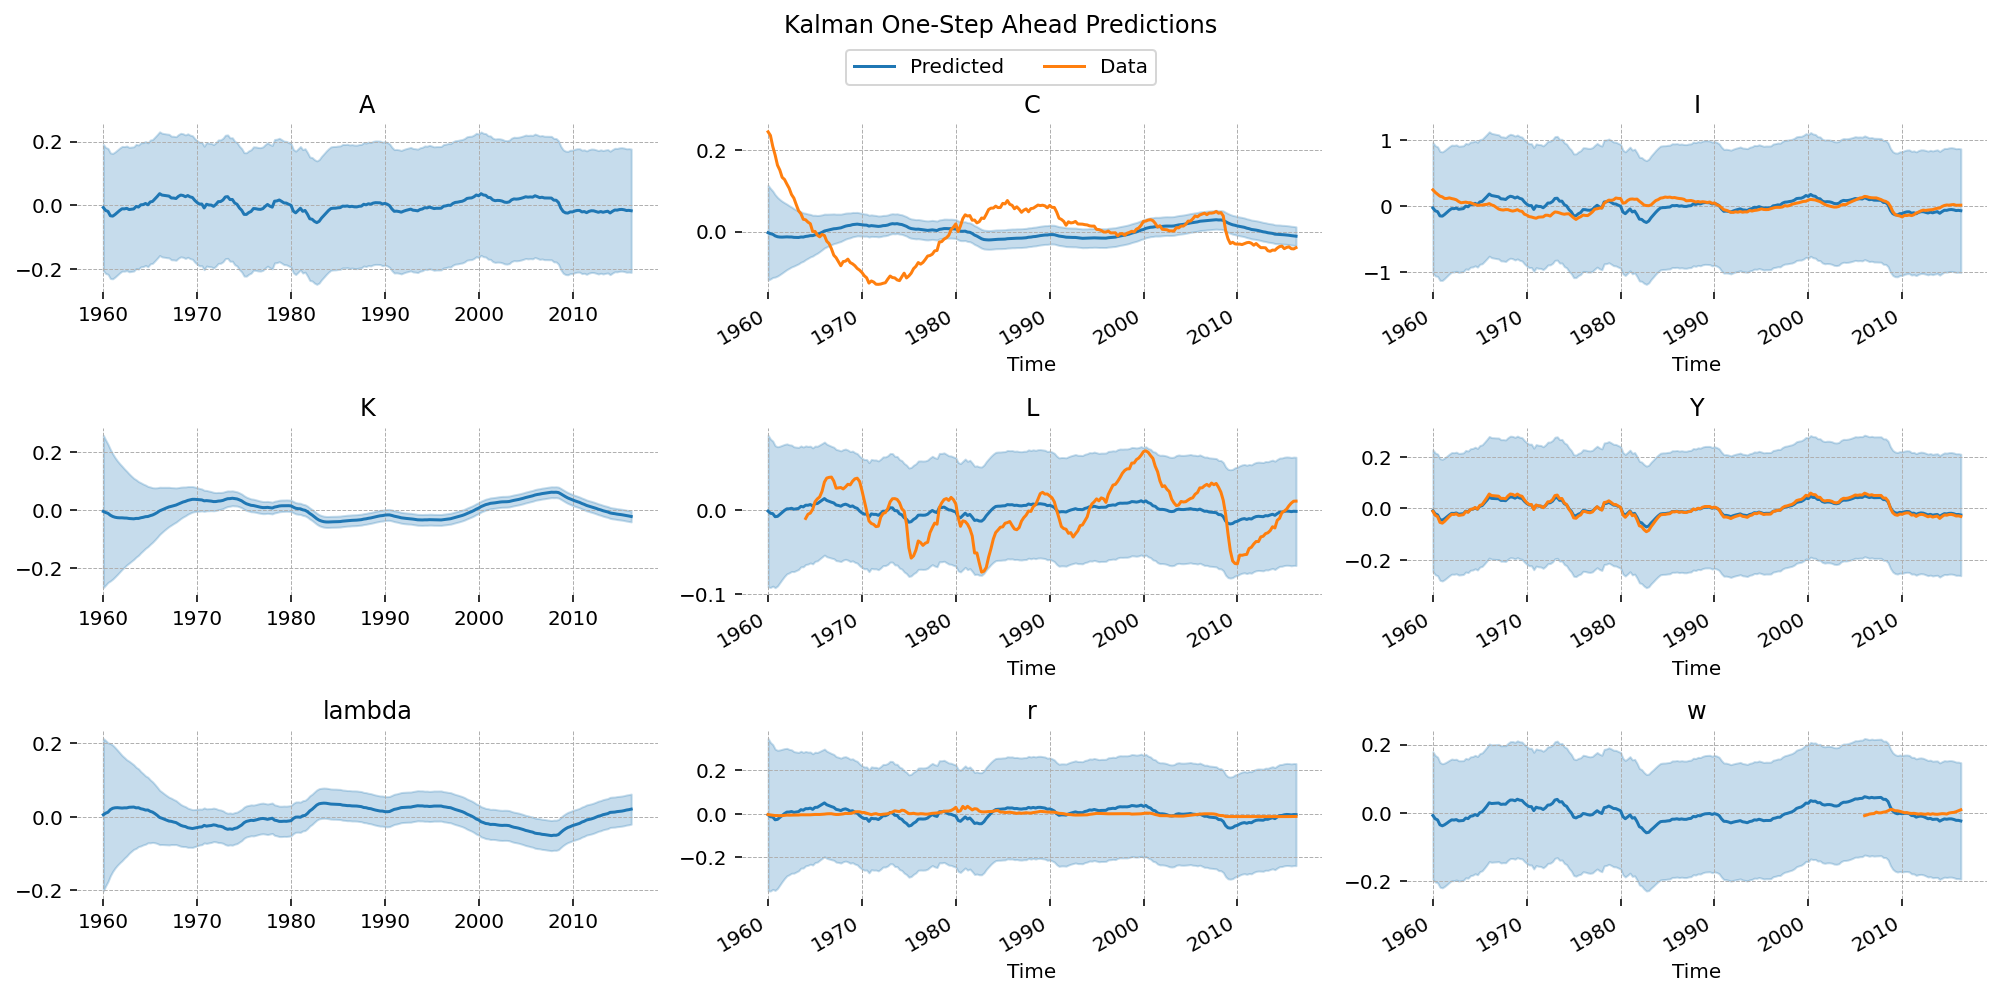

In [40]:
plot_sm_results(two_var_res, df_train_processed, var_names=vars_to_plot)

Let's check the forecast mean. I'm omitting the confidence intervals because we already know it's terrible. It actually looks a bit better for `Y`, as the rate of re-convergence to the steady-state is now matching the data.

`L` is awful, as expected.

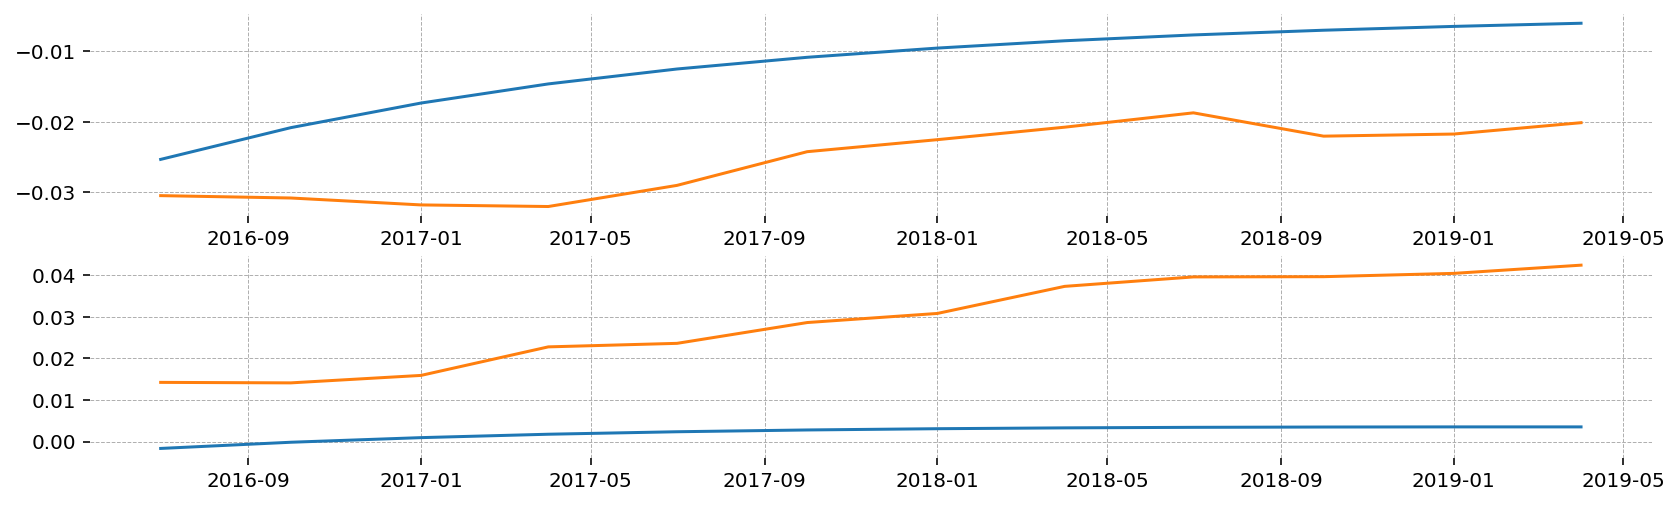

In [41]:
two_var_forecast = two_var_res.get_forecast(steps=n_test)
mu = two_var_forecast.predicted_mean

n_quarters = 12

fig, ax = plt.subplots(2, 1)
ax[0].plot(mu['Y'].iloc[:n_quarters])
ax[0].plot(df_test_processed.Y.iloc[:n_quarters])

ax[1].plot(mu['L'].iloc[:n_quarters])
ax[1].plot(df_test_processed.L.iloc[:n_quarters])

## Advice 3: Slowly add more

So now we've pretty much seen everything. Start small, just one series, and estimate only a couple variables. We could try estimating some others. Let's show the model `w`, and try to estimate `rho_A, sigma_C, sigma_L, alpha`.

In [46]:
# We want to estimate sigma_C as well now, so add it to the param_start_dict
param_start_dict = {'rho_A':0.95,
                    'sigma_C':1.5,
                    'sigma_L':2.0,
                    'alpha':0.35}

shock_start_dict = {'epsilon_A':0.5}

# Distrust labor and wage data to fix the stochastic singularity
# Let's start by distrusting wages a lot more than labor, since wages are a very noisy dataset with tons
# of missing values.
noise_start_dict = {'L':0.05,
                    'w':0.10}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=1.1, high=5.0),
                    'sigma_L':IntervalTransformer(low=1.1, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5)}

# Build the model!
three_var_mod = MLEModel(df_train_processed[['Y', 'L', 'w']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

Trying to fit `alpha` is hard, because you can get steady state failures. This is the price of using a numerically approximated steady state. If you get steady state solving errors, bring the `high` of `alpha`, `sigma_C`, and `sigma_L` down. Or go type in the steady-state equations in your GCN file so this doesn't happen!

In [47]:
three_var_res = three_var_mod.fit(method='basinhopping', stepsize=0.25, minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -2.67241
basinhopping step 1: f -2.56638 trial_f -2.56638 accepted 1  lowest_f -2.67241
basinhopping step 2: f -2.0444 trial_f -2.0444 accepted 1  lowest_f -2.67241
basinhopping step 3: f -5.14847 trial_f -5.14847 accepted 1  lowest_f -5.14847
found new global minimum on step 3 with function value -5.14847
basinhopping step 4: f -5.14847 trial_f -4.85191 accepted 0  lowest_f -5.14847
basinhopping step 5: f -5.14847 trial_f -2.5159 accepted 0  lowest_f -5.14847
basinhopping step 6: f -3.60701 trial_f -3.60701 accepted 1  lowest_f -5.14847
basinhopping step 7: f -3.60701 trial_f -3.19662 accepted 0  lowest_f -5.14847
basinhopping step 8: f -4.83715 trial_f -4.83715 accepted 1  lowest_f -5.14847
basinhopping step 9: f -4.20308 trial_f -4.20308 accepted 1  lowest_f -5.14847
basinhopping step 10: f -4.85284 trial_f -4.85284 accepted 1  lowest_f -5.14847
basinhopping step 11: f -4.85284 trial_f -4.5028 accepted 0  lowest_f -5.14847
basinhopping step 12: f -4.37032 tria

basinhopping step 65: f -4.56498 trial_f -4.56498 accepted 1  lowest_f -5.28417
basinhopping step 66: f -4.56498 trial_f 45.1374 accepted 0  lowest_f -5.28417
basinhopping step 67: f -4.56498 trial_f 4730.92 accepted 0  lowest_f -5.28417
basinhopping step 68: f -4.56498 trial_f 218.18 accepted 0  lowest_f -5.28417
basinhopping step 69: f -5.40148 trial_f -5.40148 accepted 1  lowest_f -5.40148
found new global minimum on step 69 with function value -5.40148
basinhopping step 70: f -5.40148 trial_f -3.50354 accepted 0  lowest_f -5.40148
basinhopping step 71: f -5.40148 trial_f -0.818129 accepted 0  lowest_f -5.40148
basinhopping step 72: f -4.62425 trial_f -4.62425 accepted 1  lowest_f -5.40148
basinhopping step 73: f -4.62425 trial_f -3.1182 accepted 0  lowest_f -5.40148
basinhopping step 74: f -4.62425 trial_f -2.57811 accepted 0  lowest_f -5.40148
basinhopping step 75: f -4.62425 trial_f -4.29802 accepted 0  lowest_f -5.40148
basinhopping step 76: f -4.62425 trial_f -2.44835 accepted 

We get a warning after adding the wage data, but this is expected. It's because there are so many missing values in wages, so the program can't compute certain statistics for it.

In [48]:
three_var_res.summary()

/Users/jessegrabowski/opt/anaconda3/envs/econ/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        ['Y', 'L', 'w']   No. Observations:                  226
Model:                      DSGEModel   Log Likelihood                 509.106
Date:                Sun, 04 Dec 2022   AIC                          -1004.211
Time:                        05:26:36   BIC                           -980.268
Sample:                    01-01-1960   HQIC                          -994.549
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9702      1.099      0.883      0.377      -1.184       3.125
sigma_C              1.2069     27.810      0.043      0.965     -53.300      55.714
sigma_L              3.5979    251.063      0.014      0.989    -488.477     495.672
alpha                0.1567     15.964      0.010      0.992     -31.132      31.445
sigma2.epsilon_A     0.0103      0.076      0.136      0.892      -0.138       0.159
sigma2.L             0.0251      0.014      1.815      0.070      -0.002       0.052
sigma2.w             0.0388      0.015      2.609      0.009       0.010       0.068
=======================================================================================
Ljung-Box (L1) (Q):     20.43, 218.93, 191.24   Jarque-Bera (JB):   39.11, 0.85, 658.07
Prob(Q):                     0.00, 0.00, 0.00   Prob(JB):              0.00, 0.65, 0.00
Heteroskedasticity (H):       0.39, 2.72, inf   Skew:               -0.50, -0.07, -1.71
Prob(H) (two-sided):         0.00, 0.00, 0.00   Kurtosis:             4.77, 2.74, 10.63
=======================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

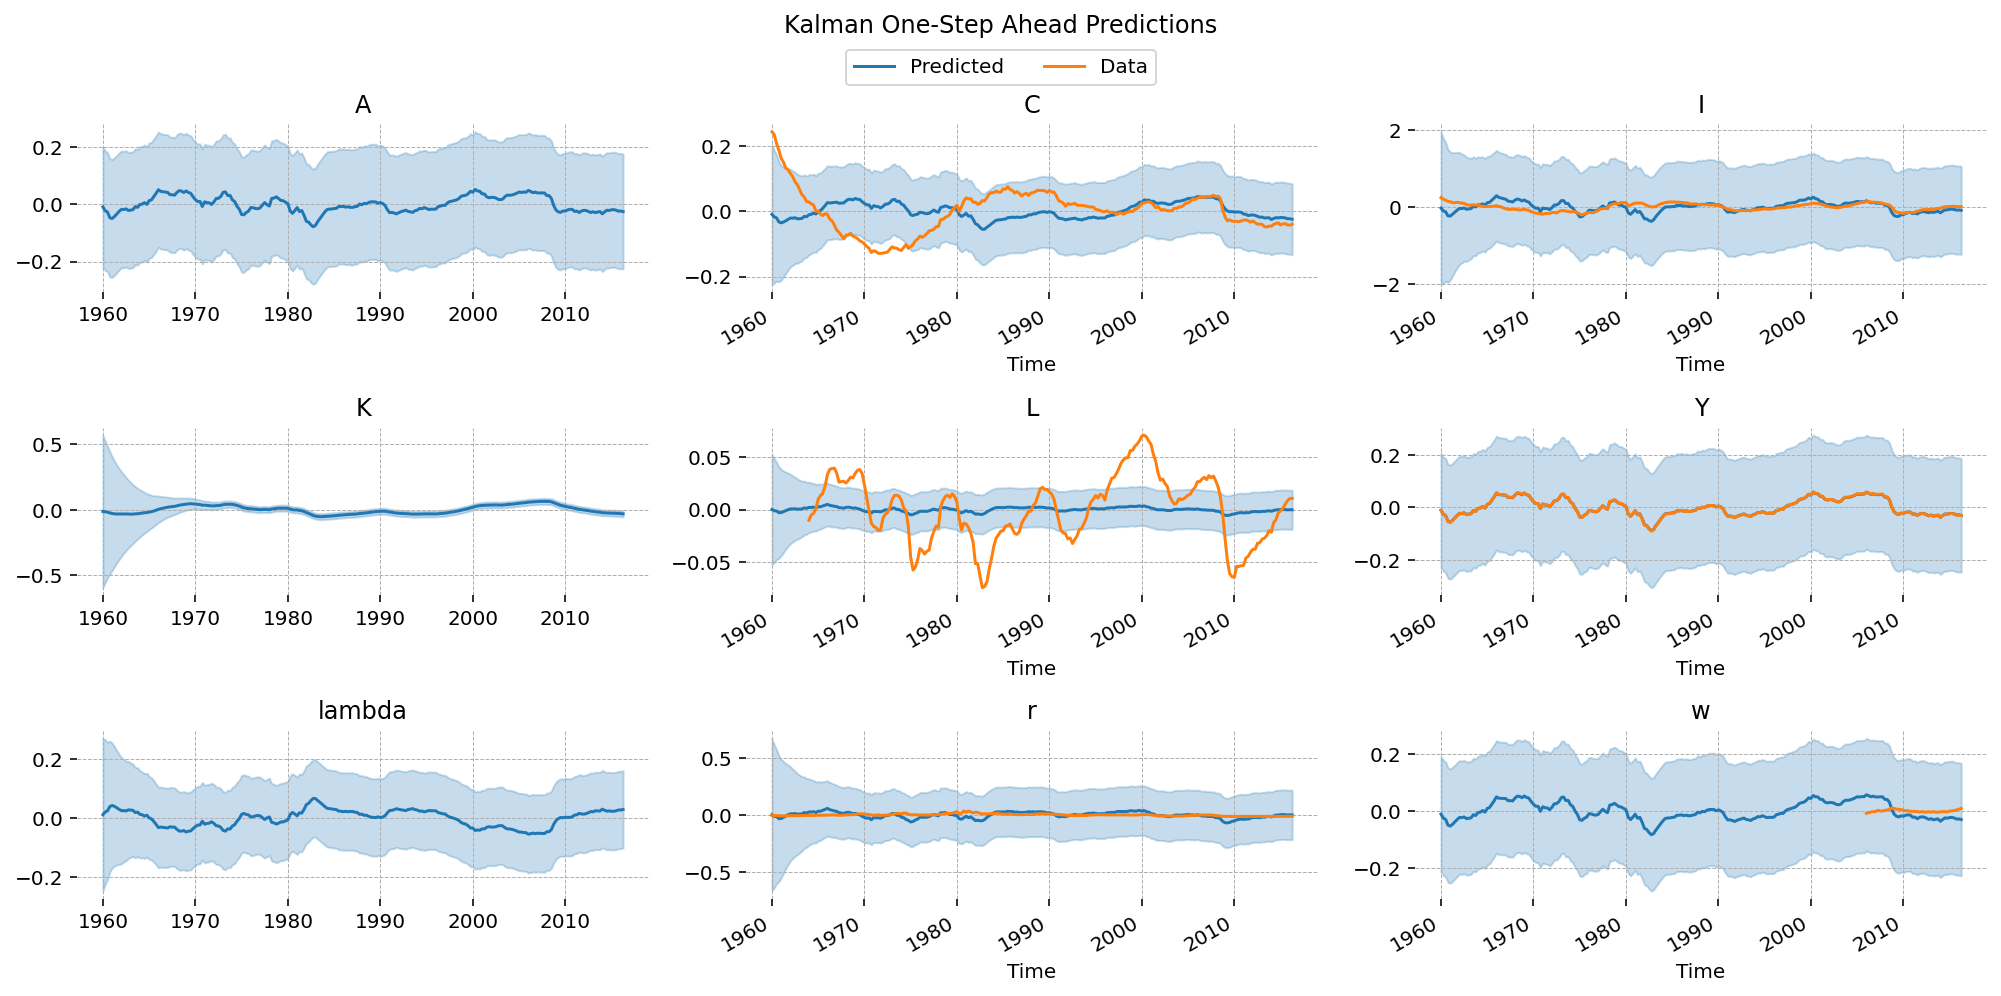

In [49]:
plot_sm_results(three_var_res, df_train_processed, var_names=vars_to_plot)

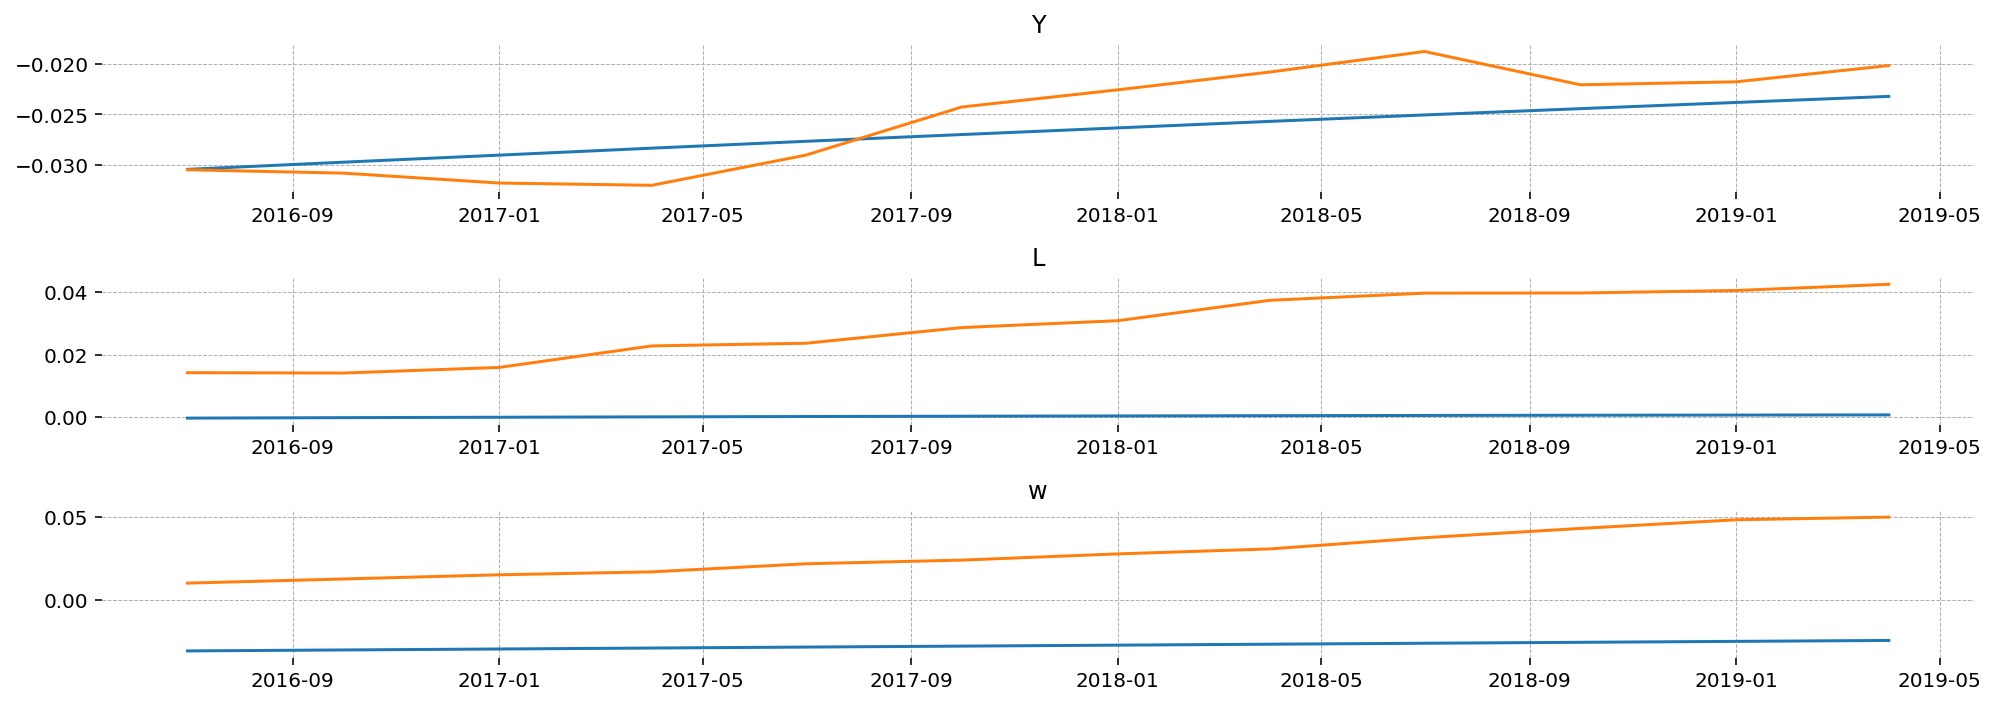

In [50]:
three_var_forecast = three_var_res.get_forecast(steps=n_test)
mu = three_var_forecast.predicted_mean

n_quarters = 12

fig, ax = plt.subplots(3, 1, figsize=(14,5))
for axis, var in zip(fig.axes, ['Y', 'L', 'w']):
    axis.plot(mu[var].iloc[:n_quarters])
    axis.plot(df_test_processed[var].iloc[:n_quarters])
    axis.set_title(var)
fig.tight_layout()
plt.show()

## Try Everything

In [51]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.95,
                    'sigma_C':1.5,
                    'sigma_L':2.0,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.05,
                    'w':0.10,
                    'r':0.05,
                    'C':0.05,
                    'I':0.05}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=1.1, high=5.0),
                    'sigma_L':IntervalTransformer(low=1.1, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
everything_mod = MLEModel(df_train_processed[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [56]:
# since we're going for so many parameters, increase maxiter
everything_res = everything_mod.fit(method='basinhopping', 
                                    niter=200,
                                    stepsize=0.25,
                                    minimizer={'method':'L-BFGS-B'})

basinhopping step 0: f -2.16012
basinhopping step 1: f -2.16012 trial_f 7.77072 accepted 0  lowest_f -2.16012
basinhopping step 2: f -3.62285 trial_f -3.62285 accepted 1  lowest_f -3.62285
found new global minimum on step 2 with function value -3.62285
basinhopping step 3: f -3.62285 trial_f -2.38116 accepted 0  lowest_f -3.62285
basinhopping step 4: f -3.62285 trial_f 2.61034 accepted 0  lowest_f -3.62285
basinhopping step 5: f -3.62285 trial_f 5.41969 accepted 0  lowest_f -3.62285
basinhopping step 6: f -3.62285 trial_f -0.273448 accepted 0  lowest_f -3.62285
basinhopping step 7: f -3.62285 trial_f -3.22836 accepted 0  lowest_f -3.62285
basinhopping step 8: f -3.62285 trial_f 30.6369 accepted 0  lowest_f -3.62285
basinhopping step 9: f -4.05238 trial_f -4.05238 accepted 1  lowest_f -4.05238
found new global minimum on step 9 with function value -4.05238
basinhopping step 10: f -3.5159 trial_f -3.5159 accepted 1  lowest_f -4.05238
basinhopping step 11: f -3.5159 trial_f 7.9219 accepte

basinhopping step 79: f -6.56446 trial_f -5.2642 accepted 0  lowest_f -8.0431
basinhopping step 80: f -6.56446 trial_f 408.775 accepted 0  lowest_f -8.0431
basinhopping step 81: f -6.56446 trial_f 29.8425 accepted 0  lowest_f -8.0431
basinhopping step 82: f -6.56446 trial_f -5.30021 accepted 0  lowest_f -8.0431
basinhopping step 83: f -6.56446 trial_f -3.96757 accepted 0  lowest_f -8.0431
basinhopping step 84: f -6.56446 trial_f 26.3236 accepted 0  lowest_f -8.0431
basinhopping step 85: f -6.56446 trial_f 1.28736 accepted 0  lowest_f -8.0431
basinhopping step 86: f -6.56446 trial_f -5.27952 accepted 0  lowest_f -8.0431
basinhopping step 87: f -6.56446 trial_f 42.0593 accepted 0  lowest_f -8.0431
basinhopping step 88: f -6.56446 trial_f -5.50982 accepted 0  lowest_f -8.0431
basinhopping step 89: f -6.56446 trial_f 12.7761 accepted 0  lowest_f -8.0431
basinhopping step 90: f -6.56446 trial_f 20.7776 accepted 0  lowest_f -8.0431
basinhopping step 91: f -6.56446 trial_f -6.17437 accepted 0

basinhopping step 153: f -5.96094 trial_f -2.81818 accepted 0  lowest_f -8.0431
basinhopping step 154: f -5.96094 trial_f 199.277 accepted 0  lowest_f -8.0431
basinhopping step 155: f -5.96094 trial_f -2.95005 accepted 0  lowest_f -8.0431
basinhopping step 156: f -5.96094 trial_f 67.3051 accepted 0  lowest_f -8.0431
basinhopping step 157: f -5.96094 trial_f 10.1645 accepted 0  lowest_f -8.0431
basinhopping step 158: f -7.01485 trial_f -7.01485 accepted 1  lowest_f -8.0431
basinhopping step 159: f -7.01485 trial_f -4.10078 accepted 0  lowest_f -8.0431
basinhopping step 160: f -6.09484 trial_f -6.09484 accepted 1  lowest_f -8.0431
basinhopping step 161: f -6.09484 trial_f 0.949411 accepted 0  lowest_f -8.0431
basinhopping step 162: f -6.09484 trial_f 6.74318 accepted 0  lowest_f -8.0431
basinhopping step 163: f -6.09484 trial_f -2.69054 accepted 0  lowest_f -8.0431
basinhopping step 164: f -6.09484 trial_f 1.22047 accepted 0  lowest_f -8.0431
basinhopping step 165: f -4.07107 trial_f -4.

In [57]:
everything_res.summary()

/Users/jessegrabowski/opt/anaconda3/envs/econ/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                  226
Model:                                  DSGEModel   Log Likelihood                 706.992
Date:                            Sun, 04 Dec 2022   AIC                          -1389.983
Time:                                    05:40:00   BIC                          -1348.937
Sample:                                01-01-1960   HQIC                         -1373.418
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9626      0.806      1.194      0.233      -0.618       2.543
sigma_C              1.2875     13.154      0.098      0.922     -24.494      27.069
sigma_L              1.9200     71.515      0.027      0.979    -138.247     142.087
alpha                0.3503      8.889      0.039      0.969     -17.073      17.773
beta                 0.9829      0.969      1.015      0.310      -0.915       2.881
delta                0.0343      0.205      0.167      0.868      -0.368       0.437
sigma2.epsilon_A     0.0084      0.065      0.129      0.898      -0.119       0.136
sigma2.L             0.0361      0.030      1.193      0.233      -0.023       0.095
sigma2.w             0.5172      0.195      2.654      0.008       0.135       0.899
sigma2.r             0.0345      0.201      0.172      0.864      -0.360       0.429
sigma2.C             0.0935      0.269      0.347      0.728      -0.434       0.621
sigma2.I             0.0909      0.220      0.414      0.679      -0.339       0.521
===================================================================================================================================
Ljung-Box (L1) (Q):     19.07, 218.88, 191.74, 210.21, 216.98, 214.99   Jarque-Bera (JB):   38.87, 1.02, 765.76, 12.10, 13.17, 2.55
Prob(Q):                           0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                0.00, 0.60, 0.00, 0.00, 0.00, 0.28
Heteroskedasticity (H):             0.39, 2.82, inf, 0.45, 0.02, 0.10   Skew:                 -0.49, -0.03, -1.89, 0.55, 0.38, 0.26
Prob(H) (two-sided):               0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Kurtosis:               4.78, 2.68, 11.19, 3.24, 3.91, 2.91
===================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

If you compare these plots to the previous ones, the uncertanty around all the series has been greatly reduced. You can see, for example, that the confidence interval around `I` has gone from +1 to -1, to +0.5 to -0.5. So we're definitely making progress here.

One lesson we should take away from this is that **shocks** are the most important thing when it comes to estimating the dynamics of the system. We added more data and estimated more parameters, but the general shape of the output is more or less the same. That's because `Y` remains our most trusted data, and the shocks from `A` drive everything. `A` changes a bit on the margins as we tweak the deep parameters, but not so much.

Our conclusion for the RBC fitting exercise can be that it does a good job for the national accounts variables that are highly correlated: Y, C, and I. It does an awful job with L, r, and w. 

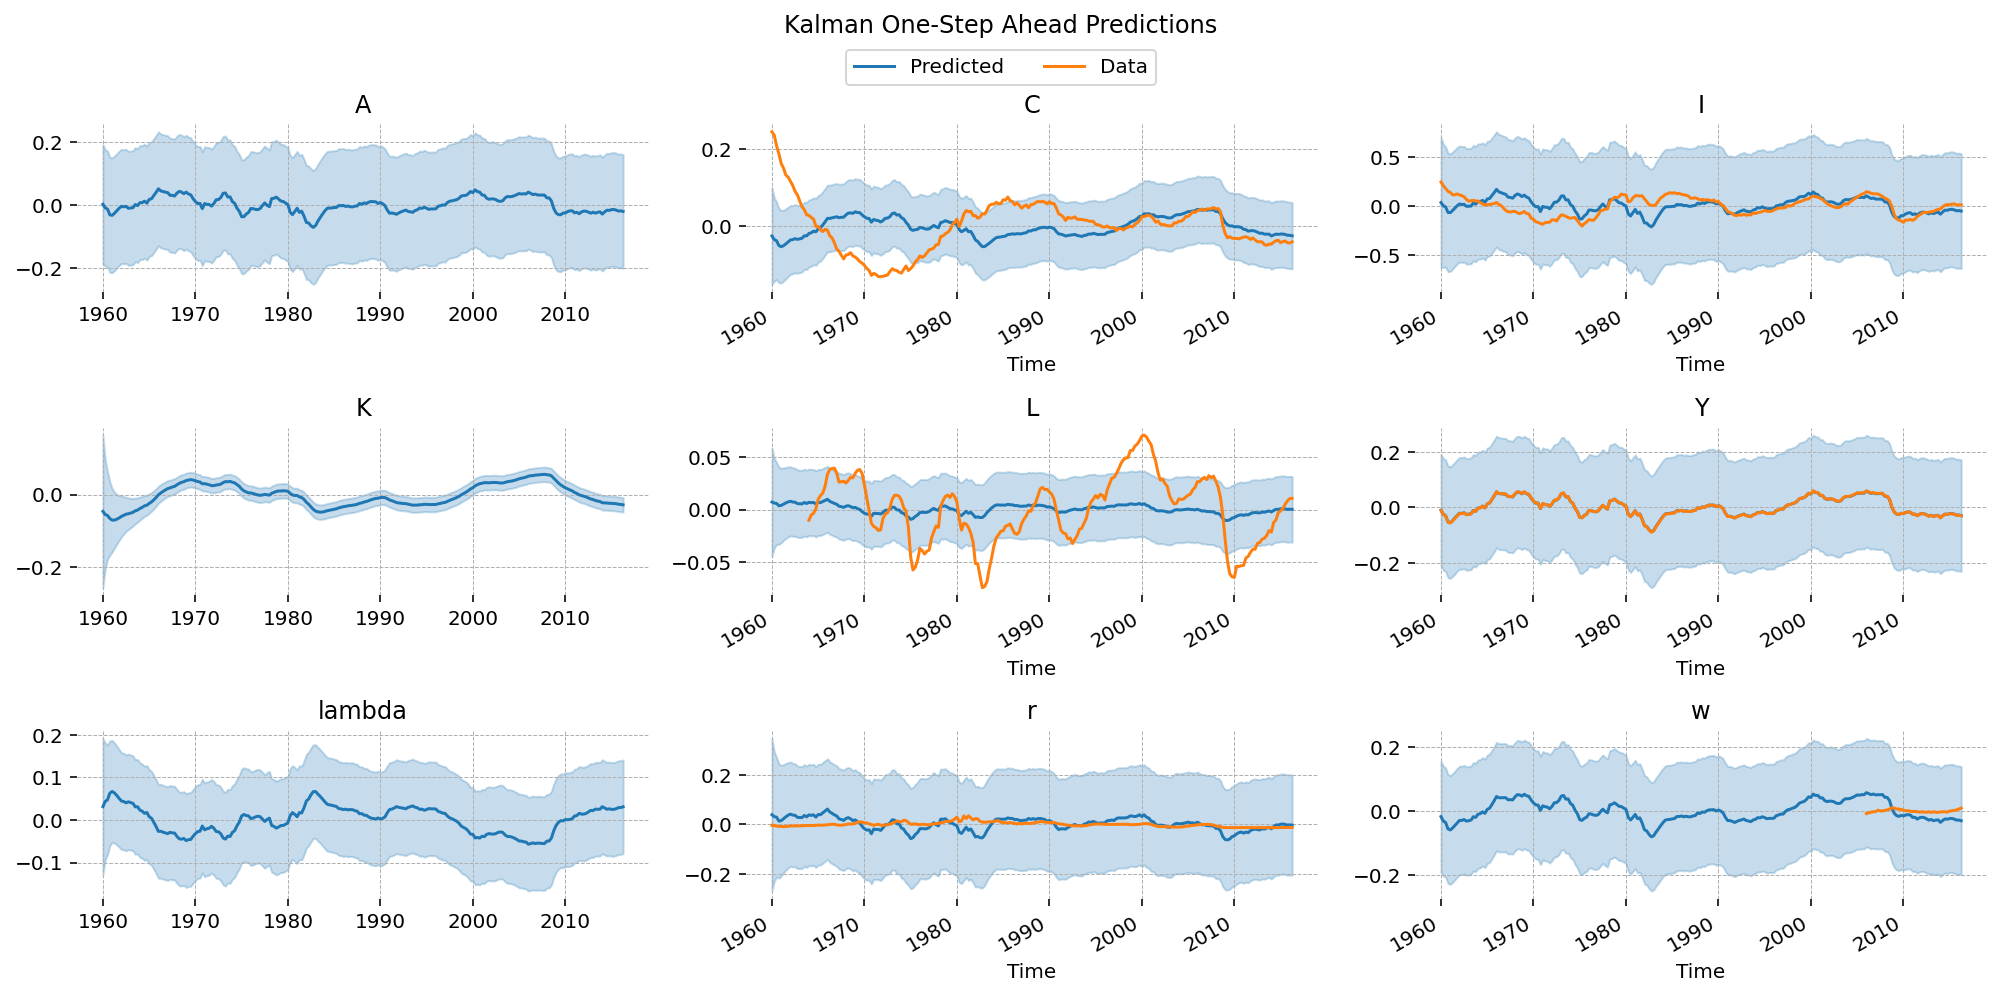

In [58]:
plot_sm_results(everything_res, df_train_processed, var_names=vars_to_plot)

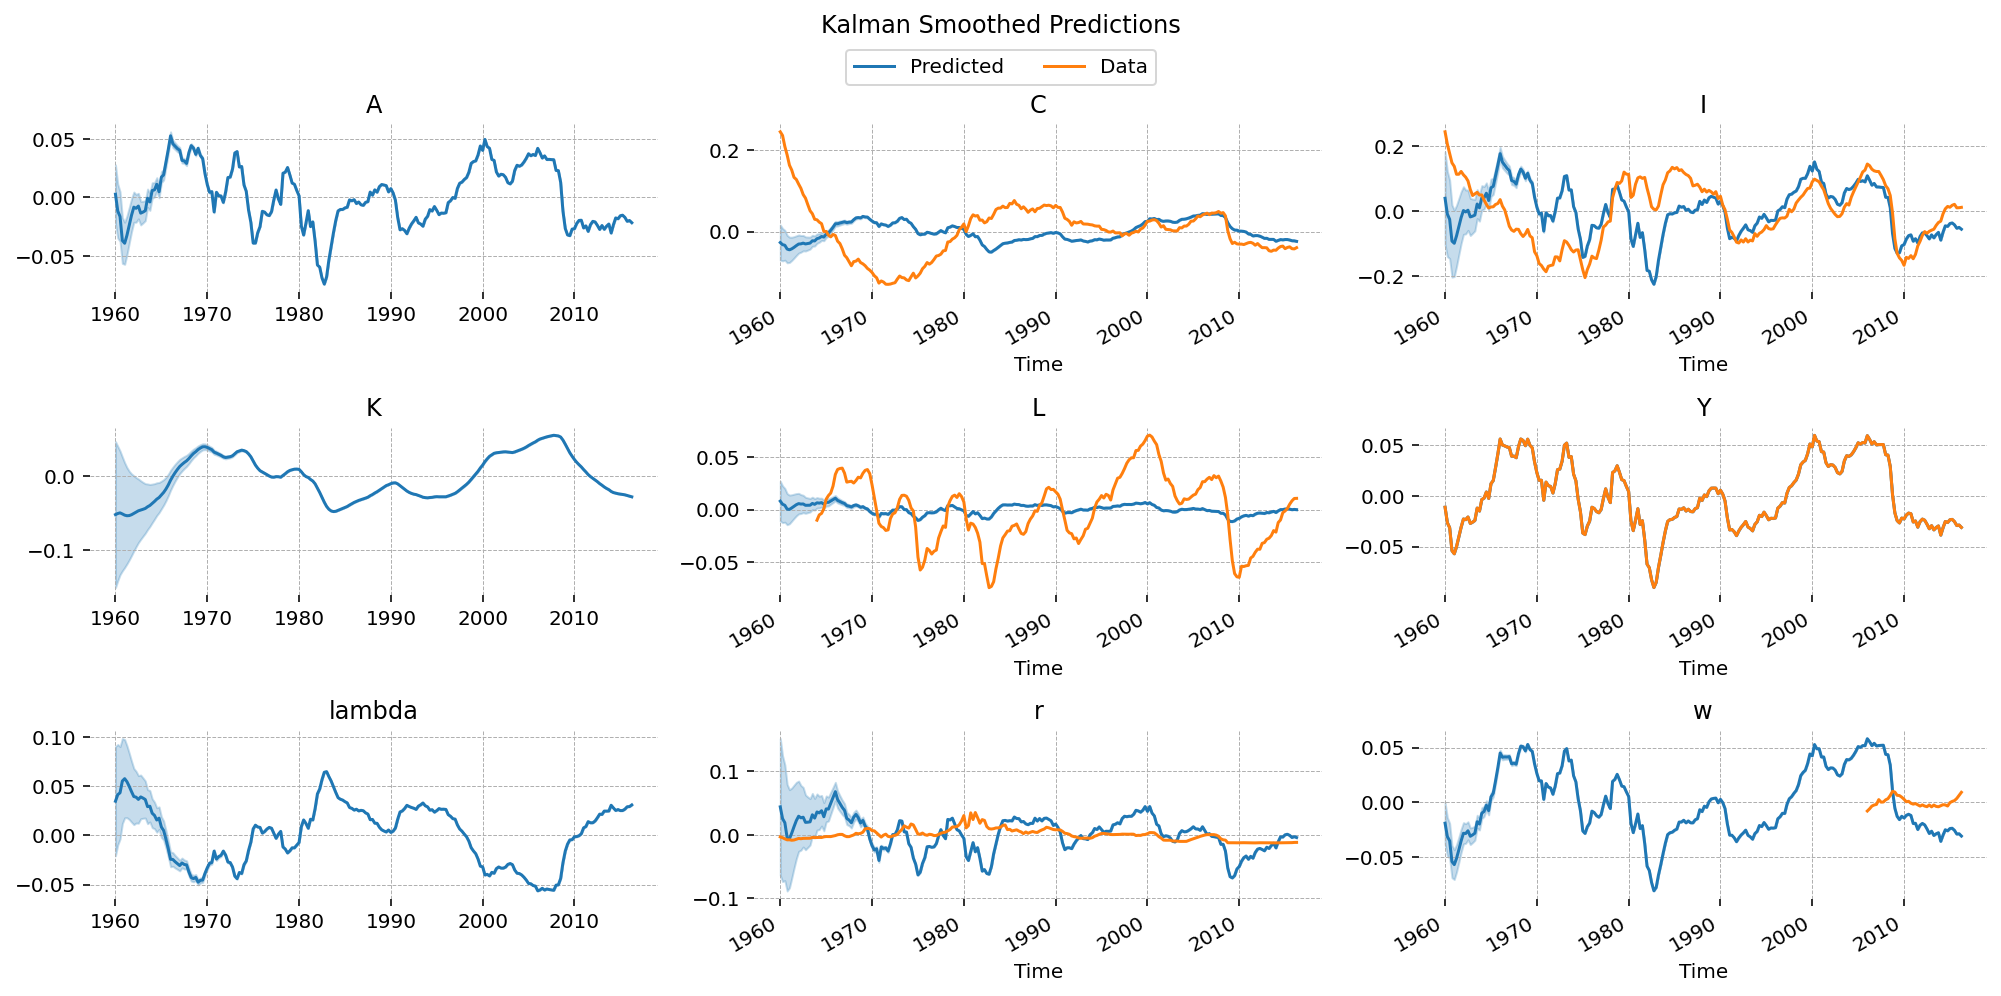

In [59]:
plot_sm_results(everything_res, df_train_processed, 'smoothed', var_names=vars_to_plot)

Looking at 4-year forecasts, GDP remains reasonable, but consumption and investment aren't very good. Interest rates endup being somewhat reasonable, but this is probably just us getting lucky. Looking at the in-sample predictions for interset rates, it seems to get it totally backwards. Our estimates go **down** during the Volker shock of the 80, and tend to generally be too responsive.

One could point out that `r` isn't really the interest rate, it's the rental rate of capital. These are closely connected -- firms issue bonds to buy capital, and the interest rate on the bonds is tightly connected to the federal funds rate -- but yes, it's not the same thing.

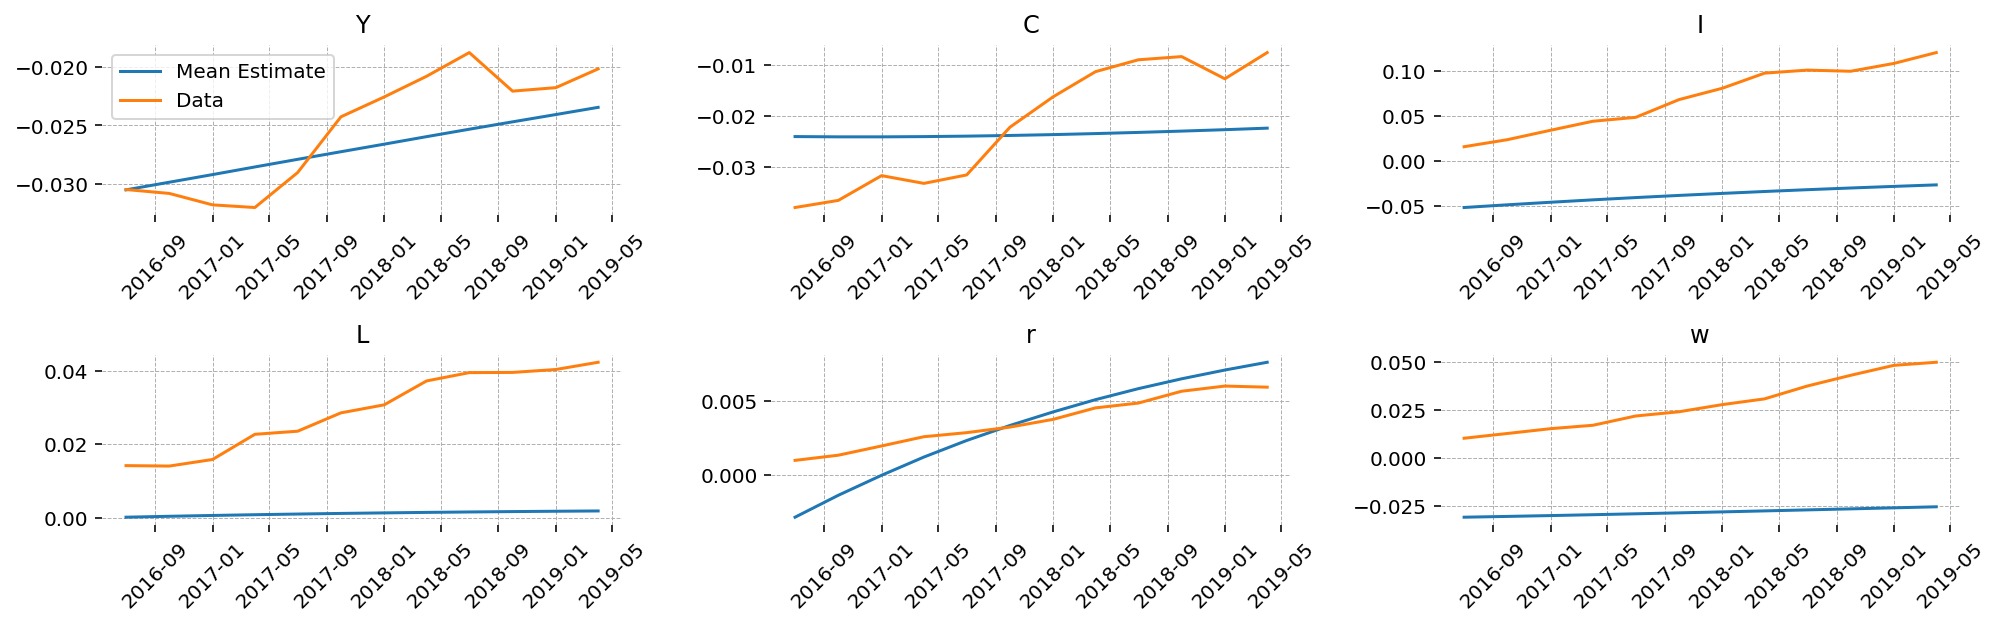

In [60]:
everything_forecast = everything_res.get_forecast(steps=n_test)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'C', 'I', 'L', 'r', 'w'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(df_test_processed[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

# Impulse Response Functions

One thing I didn't mention is that the `rbc` model will automatically update the parameters with the results of the fitting process. We can check the current parameters by looking at the `.free_param_dict` property. You can verify these are the same as shown in the regression result table above.

In [61]:
rbc.free_param_dict

{'alpha': 0.3502634234319525,
 'beta': 0.982877670928246,
 'delta': 0.03425695563645129,
 'rho_A': 0.9625803976763807,
 'sigma_C': 1.2875065033068547,
 'sigma_L': 1.9200456296957653}

As a result, it's easy to run IRFs at these estimated parameters -- just use `.impulse_response_function`

In [62]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

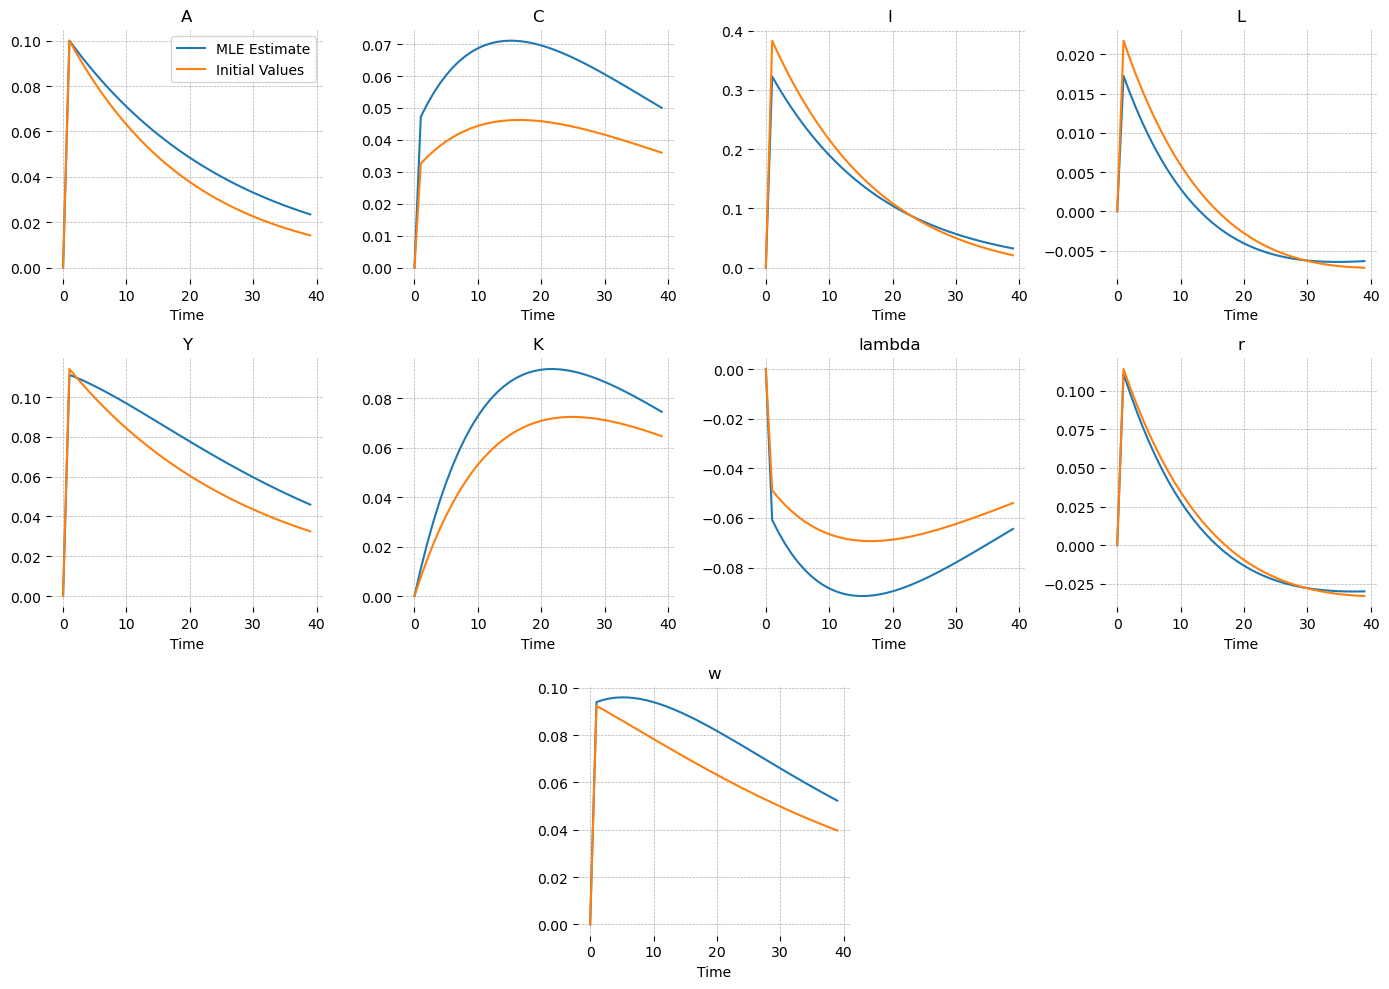

<Figure size 1400x1000 with 0 Axes>

In [64]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=vars_to_plot)
fig2 = gp.plot_irf(base_irf, vars_to_plot=vars_to_plot)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()